<font size="12">Trends in the annual snow melt-out day over the French Alps and the Pyrenees from 38 years of high resolution satellite data (1986-2023)</font>

In [1]:
project_dir = "/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/PROJECTS_BARROU-DUMONT-ZACHARIE/SP_SWH-LX-S2" #local directory


In [2]:
# A) PREPARE 38 YEARS OF SNOW DATA

In [3]:
# A.1) CLASSIFY SWH DATA

In [ ]:
# A.1.1) MAKE LISTS OF SWH DATA USING S3FS
#use kernel s3-env
#if s3fs generate errors, try running the command 'kinit' (followed by pwd) in the console before trying again.
import os
from assumerole import assumerole
import s3fs

lists_path = os.path.join(project_dir,"DATA",'SWH_THEIA',"LISTS_txt")


ENDPOINT_URL="https://s3.datalake.cnes.fr"
credentials = assumerole.getCredentials("arn:aws:iam::732885638740:role/public-read-only-OT", Duration=7200)
s3 = s3fs.S3FileSystem(
      client_kwargs={
                      'aws_access_key_id': credentials['AWS_ACCESS_KEY_ID'],
                
          'aws_secret_access_key': credentials['AWS_SECRET_ACCESS_KEY'],
                      'aws_session_token': credentials['AWS_SESSION_TOKEN'],
         'endpoint_url': 'https://s3.datalake.cnes.fr'
      }
   )

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}
for mtn in ["PYR","ALP"]:
    for sat in ["SPOT1","SPOT2","SPOT3","SPOT4","SPOT5"]:
        for year in range(1986,2016):
            os.system("rm "+os.path.join(lists_path,mtn,f"{mtn}_{str(sat)}_{str(year)}.txt"))
            for K in range(SPOT_tile[mtn]["KMIN"],SPOT_tile[mtn]["KMAX"]+1):
                for J in range(SPOT_tile[mtn]["JMIN"],SPOT_tile[mtn]["JMAX"]+1):
                    s3_list = s3.glob(f"muscate/SPOTWORLDHERITAGE/{str(year)}/**/{str(sat)}*_0{str(K)}-{str(J)}-*.zip")
                    if len(s3_list) > 0:
                        with open(os.path.join(lists_path,mtn,f"{mtn}_{str(sat)}_{str(year)}.txt"), 'a') as fp:
                            for item in s3_list:
                                fp.write(item+"\n")  

In [ ]:
# A.1.2) APPLY UNET ON SWH LISTS
import os
model = "TCD-BLUE_AVG-1200"
model_dir = os.path.join(project_dir,"MODELS",model)
out_dir = os.path.join(project_dir,'DATA','SWH_INFERENCE',model)

for mtn in ["PYR","ALP"]:
    lists_path = os.path.join(project_dir,"DATA",'SWH_THEIA',"LISTS_txt",mtn)
    for i,ll in enumerate(os.listdir(lists_path)):

        script_path = os.path.join(project_dir,"CODE","run_snow_swh_job.sh")
        export =  ",".join(
            [
                f"INPUT_PATH=\"{os.path.join(lists_path,ll)}\"", f"OUTPUT_PATH=\"{out_dir}\"", f"MODELS_PATH=\"{model_dir}\"", f"KEEP_REFL=\"0\"", f"MASK=\"1\""
            ]
        )
        job_common_params =  " ".join(
            [
                "-A","cnes_level2",
                f" --job-name=INF_{i}",
                " --time=00:09:59",
                "-N","1","-n","8",
                "--mem=196G",
                "-o",f"{project_dir}/CODE/logs/INF_{i}",
                f"--export=ALL,{export}",script_path
            ]
        )
        os.system("sbatch "+job_common_params)  

In [ ]:
# A.2) COMPARISON BETWEEN SWH AND DLR SNOW PRODUCTS

In [ ]:
# A.2.1) GET SWH AND DLR PAIRS
import os
import glob
from datetime import datetime, timedelta
import re
import json

def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
            date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
            break
    return date


LANDSAT_tiles_wrs={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["199030","200030"],
        "30TYN":["199030","200030"],
        "31TCH":["198030","198031","199030"],
        "31TDH":["197031","198030","198031"]
    }
}

LANDSAT_path = f"{project_dir}/DATA/LANDSAT_QA_DLR"

SWH_path= f"{project_dir}/DATA/SWH_INFERENCE/TCD-ONLY_AVG-1200"


pair_dict = {} 
for mtn in ['ALP','PYR']:
    pair_dict[mtn] = {}
    for year in range(1986,2016):
        landsat_list = glob.glob(os.path.join(LANDSAT_path,f'{mtn}_LIS',f'FSC_{year}*'),recursive=True)
        if len(landsat_list) == 0 : continue
        for s in ["SPOT1","SPOT2","SPOT3","SPOT4","SPOT5"]:
            spot_list = glob.glob(os.path.join(SWH_path,f'{mtn}',s,str(year),'*','*',f'{s}*'),recursive=True)
            #print(spot_list)
            len_spot = len(spot_list)
            if len_spot == 0:continue
            #print(len_spot)
            for k,spot_inf in enumerate(spot_list):
                d = getDateFromStr(os.path.basename(spot_inf))
                #print(spot_inf)
                day = str(d.day)
                month = str(d.month)
                year=str(d.year)
                found = False
                for tile in os.listdir(spot_inf):
                    for wrs in LANDSAT_tiles_wrs[mtn][tile]:
                        for landsat_dlr in landsat_list:
                            landsat_name = os.path.basename(landsat_dlr)
                            if year+'{:02d}'.format(d.month)+'{:02d}'.format(d.day) == landsat_name[4:12] and wrs == landsat_name[-6:]:
                                ins = landsat_name[20:24]
                                if tile not in pair_dict[mtn]: pair_dict[mtn][tile]={}
                                if s not in pair_dict[mtn][tile]: pair_dict[mtn][tile][s]={}
                                if ins not in pair_dict[mtn][tile][s] : pair_dict[mtn][tile][s][ins] = {}
                                if year not in pair_dict[mtn][tile][s][ins]: pair_dict[mtn][tile][s][ins][year]={}
                                if month not in pair_dict[mtn][tile][s][ins][year]: pair_dict[mtn][tile][s][ins][year][month]={}
                                if day not in pair_dict[mtn][tile][s][ins][year][month]: pair_dict[mtn][tile][s][ins][year][month][day]=[]
                                pair_dict[mtn][tile][s][ins][year][month][day]=[os.path.basename(spot_inf),landsat_dlr]
                                found = True
                                break
                        if found:break
                    if found:break
                print(f"{mtn}_{year}_{s}_{k+1}/{len_spot}",end="                   \r")
                
with open(f'{project_dir}/DATA/PAIRS/pair_landsat_swh.json', 'w') as fp:
    json.dump(pair_dict, fp)


In [ ]:
# A.2.2) GENERATE DATAFRAME OF SWH-DLR PAIRS INCLUDING THE TIME DIFFERENCE (IN SECONDS) BETWEEN THE PAIR
# THE ACQUISITION TIME OF THE ORIGINAL LANDSAT PRODUCT IS ASSOCIATED TO THE DLR PRODUCT
import os
import glob
from datetime import datetime, timedelta
import re
import json
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
from pyproj import Proj, transform
import pandas as pd

S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}


def reproject(inEPSG,outEPSG,x1,y1):
    
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    return x2, y2

def getOverlapCoords(G1,G2):
    
    epsg1 = (osr.SpatialReference(wkt=G1.GetProjection())).GetAttrValue('AUTHORITY',1)
    epsg2 = (osr.SpatialReference(wkt=G2.GetProjection())).GetAttrValue('AUTHORITY',1)
    GT1 = G1.GetGeoTransform()
    minx1 = GT1[0]
    maxy1 = GT1[3]
    maxx1 = minx1 + GT1[1] * G1.RasterXSize
    miny1 = maxy1 + GT1[5] * G1.RasterYSize
    
    GT2 = G2.GetGeoTransform()
    minx2 = GT2[0]
    maxy2 = GT2[3]
    maxx2 = minx2 + GT2[1] * G2.RasterXSize
    miny2 = maxy2 + GT2[5] * G2.RasterYSize
    
    if epsg1 not in epsg2 :
        minx1 , miny1 = reproject(epsg1,epsg2,minx1,miny1)
        maxx1 , maxy1 = reproject(epsg1,epsg2,maxx1,maxy1)
    
    
    minx3 = max(minx1,minx2)
    maxy3 = min(maxy1,maxy2)
    maxx3 = min(maxx1,maxx2)
    miny3 = max(miny1,miny2)   
    
    # no intersection 
    if (minx3 > maxx3 or miny3 > maxy3) : 
        return None,None,None,None
    
    return minx3, maxy3, maxx3, miny3  #projection de G2

def getTimeFromStr(N,):
    sepList = ["","-","_"]
    HHMMSS = ''
    for s in sepList :
        found = re.search('-'+'\d{2}'+ s +'\d{2}'+ s +'\d{2}'+'-'+'\d{3}'+'_', N)
        if found != None :
            HHMMSS = datetime.strptime(found.group(0), '-'+'%H'+ s +'%M'+ s +'%S'+"-"+'%f'+'_')
            break
    return HHMMSS


with open(f'{project_dir}/DATA/PAIRS/pair_landsat_swh.json', 'r') as fp:
    data = json.load(fp)
    
model_lists = ["TCD-BLUE_AVG-1200","TCD-CIRRUS-BLUE_AVG-1200","TCD-ONLY_AVG-1200"]
LANDSAT_path = f"{project_dir}/DATA/LANDSAT_QA_DLR"
SWH_path= f"{project_dir}/DATA/SWH_INFERENCE"
TCD_list_path = "/work/datalake/static_aux/TreeCoverDensity"
DEM_list_path="/work/CAMPUS/etudes/Neige/DEM"
USGS_PATH = f"{project_dir}/DATA/USGS"


pair_perf_dict={"MTN":[],"TILE":[],"SPOT":[],"LANDSAT":[],"YEAR":[],"MONTH":[],"MODEL":[],"TYPE":[],"METRIC":[],"VALUE":[],"ΔTIME":[]}
count=0
err = "start"
for mtn in data:
    for tile in data[mtn]:
        TCD_path = glob.glob(os.path.join(TCD_list_path,tile,f'TCD_{tile}.???'),recursive=True)[0]
        TCD_raster = gdal.Open(TCD_path)
        epsg_S2 = S2_tiles[mtn][tile]['EPSG']
        for s in data[mtn][tile]:
            for l in data[mtn][tile][s]:
                pd_l = pd.read_csv(glob.glob(os.path.join(USGS_PATH,f"{mtn}*{l}*.csv"))[0], encoding='unicode_escape')
                pd_l = pd_l[pd_l['Landsat Product Identifier L1'].str.contains(l)]
                for year in data[mtn][tile][s][l]:
                    for month in data[mtn][tile][s][l][year]:
                        len_m = len(data[mtn][tile][s][l][year][month])
                        for k,day in enumerate(data[mtn][tile][s][l][year][month]):
                            print(f"{mtn} {tile} {s} {l} {year} {month} {k+1}/{len_m} in dict:{count} error: {err}",end="                   \r")
                            swh = data[mtn][tile][s][l][year][month][day][0]
                            landsat = data[mtn][tile][s][l][year][month][day][1]
                            landsat_path = glob.glob(os.path.join(landsat,'*FSCTOC.tif'))[0]
                            L_raster = gdal.Open(landsat_path)

                            epsg_L = (osr.SpatialReference(wkt=L_raster.GetProjection())).GetAttrValue('AUTHORITY',1)
                            minx, maxy, maxx, miny = getOverlapCoords(TCD_raster,L_raster)
                            
                            # no intersection 
                            if minx is None: 
                                err = "no intersect"
                                continue

                            if epsg_S2 != epsg_L:
                                TCD = gdal.Warp("",TCD_raster,format= 'MEM',dstSRS="EPSG:" + epsg_L,resampleAlg="near")
                                TCD = gdal.Warp("",TCD,format= 'MEM',resampleAlg="near",
                                                outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                            else:
                                TCD = gdal.Warp("",TCD_raster,format= 'MEM',resampleAlg="near",
                                                outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                
                            L = gdal.Warp("",L_raster,format= 'MEM',resampleAlg="near",
                                          outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                            
                            epsg_L_2 = (osr.SpatialReference(wkt=L.GetProjection())).GetAttrValue('AUTHORITY',1)
                            epsg_TCD_2 = (osr.SpatialReference(wkt=TCD.GetProjection())).GetAttrValue('AUTHORITY',1)
                            TCD_array = (TCD.ReadAsArray()).flatten()
                            L_array = (L.ReadAsArray()).flatten()

                            #on retire les TCD
                            L_array = L_array[TCD_array <= 50]
                            if len(L_array[L_array == 0]) < 10 or \
                            len(L_array[L_array == 100]) < 10 or \
                            len(L_array[L_array == 205]) < 10: 
                                err= "small pixel number landsat"
                                continue
                            
                            #check that swh is available in both models
                            all_here = True
                            for model in model_lists : 
                                swh_path = glob.glob(os.path.join(SWH_path,model,mtn,s,year,month,day,swh,tile,'*','*FSCTOC.tif'))
                                if len(swh_path) == 0 :
                                    all_here = False
                                    err="model missing"
                                    break
                            if not all_here : continue
                            
                            #get swh time
                            swh_date = year+'{:02d}'.format(int(month))+'{:02d}'.format(int(day))

                            d_swh =getTimeFromStr(swh)
                            #get landsat mtd
                            wrs = landsat[-6:]
                            pd_l_2 = pd_l[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_")]
                            l_start_time = (pd_l_2.loc[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_"), 'Start Time'].values[0]).split()[1]
                            l_stop_time = (pd_l_2.loc[pd_l['Landsat Product Identifier L1'].str.contains(f"_{wrs}_{swh_date}_"), 'Stop Time'].values[0]).split()[1]
                            if "." not in l_start_time: l_start_time  = l_start_time + ".0"
                            if "." not in l_stop_time: l_stop_time  = l_stop_time + ".0"
                            d_start = datetime.strptime(l_start_time, "%H:%M:%S.%f")
                            d_stop = datetime.strptime(l_stop_time, "%H:%M:%S.%f")
                            d_delta = abs((d_start+((d_stop - d_start)/2) - d_swh).total_seconds())
                            for model in model_lists : 
                                swh_path = glob.glob(os.path.join(SWH_path,model,mtn,s,year,month,day,swh,tile,'*','*FSCTOC.tif'))[0]
                                SWH_raster = gdal.Open(swh_path)
                                if epsg_S2 != epsg_L:
                                    SWH = gdal.Warp("",SWH_raster,format= 'MEM',dstSRS="EPSG:" + epsg_L,
                                                    resampleAlg="near")
                                    SWH = gdal.Warp("",SWH,format= 'MEM',resampleAlg="near",outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                else:
                                    SWH = gdal.Warp("",SWH_raster,format= 'MEM',resampleAlg="near",outputBounds=[minx,miny,maxx,maxy],xRes= 30,yRes= 30)
                                SWH_array = (SWH.ReadAsArray()).flatten()
                                SWH_array = SWH_array[TCD_array <= 50]
                                if len(SWH_array[SWH_array<255]) == 0: 
                                    err= "only nodata swh"
                                    continue
                                perf = np.where(((L_array == 0) & (SWH_array == 0)),0,      
                                    np.where(((L_array == 0) & (SWH_array == 100)),1,    
                                    np.where(((L_array == 0) & (SWH_array == 205)),2,    
                                    np.where(((L_array == 100) & (SWH_array == 0)),3,    
                                    np.where(((L_array == 100) & (SWH_array == 100)),4,    
                                    np.where(((L_array == 100) & (SWH_array == 205)),5,    
                                    np.where(((L_array == 205) & (SWH_array == 0)),6,    
                                    np.where(((L_array == 205) & (SWH_array == 100)),7,    
                                    np.where(((L_array == 205) & (SWH_array == 205)),8,255)))))))))    
                                    
                                GG = len(perf[perf==0])
                                GS = len(perf[perf==1])
                                GC = len(perf[perf==2])
                                SG = len(perf[perf==3])
                                SS = len(perf[perf==4])
                                SC = len(perf[perf==5])
                                CG = len(perf[perf==6])
                                CS = len(perf[perf==7])
                                CC = len(perf[perf==8])
                                pair_perf_dict["MTN"].extend([mtn]*9)
                                pair_perf_dict["TILE"].extend([tile]*9)
                                pair_perf_dict["SPOT"].extend([s]*9)
                                pair_perf_dict["LANDSAT"].extend([l]*9)
                                pair_perf_dict["YEAR"].extend([int(year)]*9)
                                pair_perf_dict["MONTH"].extend([int(month)]*9)
                                pair_perf_dict["MODEL"].extend([model[:-9]]*9)
                                pair_perf_dict["ΔTIME"].extend([int(d_delta)]*9)
                                pair_perf_dict["TYPE"].extend(["COUNT"]*9)
                                pair_perf_dict["METRIC"].extend(["GG","GS","GC",
                                                                 "SG","SS","SC",
                                                                 "CG","CS","CC"])
                                pair_perf_dict["VALUE"].extend([GG,GS,GC,
                                                                SG,SS,SC,
                                                                CG,CS,CC])
                                count += 1
                                err= "worked!"
                                
df = pd.DataFrame(data=pair_perf_dict)
df.to_pickle(f'{project_dir}/DATA/PAIRS/dict_pair_landsat_swh.pkl')  


In [9]:
# A.2.3) SNOW, GROUND, CLOUD LABELS DISTRIBUTION
import pandas as pd

df = pd.read_pickle(f'{project_dir}/DATA/PAIRS/dict_pair_landsat_swh.pkl')
spot_count = (df.query("MTN == 'ALP' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT'   ").reset_index())['VALUE'].count()/9
spot_s = (df.query("MTN == 'ALP' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GS' | METRIC == 'SS' | METRIC == 'CS' ) ").reset_index())['VALUE'].sum()
spot_c = (df.query("MTN == 'ALP' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GC' | METRIC == 'CC' | METRIC == 'SC' ) ").reset_index())['VALUE'].sum()
spot_g = (df.query("MTN == 'ALP' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GG' | METRIC == 'SG' | METRIC == 'CG' )  ").reset_index())['VALUE'].sum()
all_px = (df.query("MTN == 'ALP' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT'  ").reset_index())['VALUE'].sum()
print(all_px)
print(spot_s/all_px*100)
print(spot_c/all_px*100)
print(spot_g/all_px*100)
print(spot_count)
print("\n")
spot_count = (df.query("MTN == 'PYR' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' ").reset_index())['VALUE'].count()/9
spot_s = (df.query("MTN == 'PYR' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GS' | METRIC == 'SS' | METRIC == 'CS' ) ").reset_index())['VALUE'].sum()
spot_c = (df.query("MTN == 'PYR' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GC' | METRIC == 'CC' | METRIC == 'SC' ) ").reset_index())['VALUE'].sum()
spot_g = (df.query("MTN == 'PYR' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT' & (METRIC == 'GG' | METRIC == 'SG' | METRIC == 'CG' )  ").reset_index())['VALUE'].sum()
all_px = (df.query("MTN == 'PYR' & MODEL == 'TCD-BLUE' & TYPE == 'COUNT'  ").reset_index())['VALUE'].sum()
print(all_px)
print(spot_s/all_px*100)
print(spot_c/all_px*100)
print(spot_g/all_px*100)
print(spot_count)

325479996
12.961113591755113
28.1057444771506
58.933141931094276
726.0


430528792
8.803912468646232
26.65156782359866
64.54451970775511
614.0


In [ ]:
# A.2.4) CONTINGENCY MATRIX BETWEEN SWH AND DLR
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def cm_2x2_metrics(g):
    RECALL_SNOW = g['SS'].sum()/float(g['SS'].sum() + g['SG'].sum())
    PRECISION_SNOW = g['SS'].sum()/float(g['SS'].sum() + g['GS'].sum())
    RECALL_GROUND = g['GG'].sum()/float(g['GG'].sum() + g['GS'].sum())
    PRECISION_GROUND = g['GG'].sum()/float(g['GG'].sum() + g['SG'].sum())
    F1_SNOW = 2*PRECISION_SNOW*RECALL_SNOW/(PRECISION_SNOW+RECALL_SNOW)
    F1_GROUND = 2*PRECISION_GROUND*RECALL_GROUND/(PRECISION_GROUND+RECALL_GROUND)

        
    return pd.Series( {"RECALL GROUND":RECALL_GROUND,
        "PRECISION GROUND":PRECISION_GROUND,
        "F1 GROUND":F1_GROUND,
        "RECALL SNOW":RECALL_SNOW,
        "PRECISION SNOW":PRECISION_SNOW,
        "F1 SNOW":F1_SNOW} )

plot_path = f"{project_dir}/DATA/PAIRS"


df = pd.read_pickle(f'{project_dir}/DATA/PAIRS/dict_pair_landsat_swh.pkl')

df2 = df.drop(columns=['TYPE'])
df2 = df2.pivot_table(
    values='VALUE',
    index=['MTN', 'TILE', "SPOT","LANDSAT","YEAR","MONTH","MODEL","ΔTIME"],
    columns='METRIC'
    )
df2.reset_index(inplace=True)
df2.columns.name = None
df2["COUNT_CLOUD"] = df2["CG"]+ df2["CS"]+ df2["CC"]
df2 = df2.replace("TCD-BLUE", "TB")
df2 = df2.replace("TCD-ONLY", "TO")
df2 = df2.replace("TCD-CIRRUS-BLUE", "TBC")
df_2x2b = df2.groupby(['MODEL'], as_index=False).apply( cm_2x2_metrics )
df_2x2 = df_2x2b.melt(id_vars=['MODEL'], value_vars=['RECALL GROUND',
                                                    'PRECISION GROUND',
                                                    'F1 GROUND',
                                                    'RECALL SNOW',
                                                    'PRECISION SNOW',
                                                    'F1 SNOW'],var_name='METRICS', value_name='VALUES')
print(df_2x2.query(" METRICS.str.contains('SNOW') & MODEL == 'TB'",engine="python"))
fig, axs = plt.subplots()
sn.barplot(ax=axs,data = df_2x2.query(" METRICS.str.contains('SNOW') & MODEL == 'TB'",engine="python"),x = 'METRICS',y='VALUES',color="darkgrey")
#axs.get_legend().remove()
axs.set_ylim([0.97, 0.995])
#plt.legend(ncol=4)
axs.set_xlabel('')
axs.set_ylabel('')
fig.set_figwidth(10)
fig.set_figheight(3)
fig.tight_layout()
plt.savefig(op.join(plot_path,f'contingency_matrix_pairs_swh_dlr.pdf'),format="pdf",transparent=False,facecolor='white')


In [ ]:
# B) CREATE ANNUAL SNOW PHENOLOGY (SP) DATA

In [ ]:
# B.1) CREATE SP FROM SENTINEL-2 AND LANDSAT 7-8 FOR HYDRO YEARS 2015 AND 2016
#SP data for after 2016 are already available from hydroweb or theia
#LIS algorithm is used for the SP
import os
from osgeo import osr, ogr, gdal
import json
import glob
from datetime import datetime, timedelta, date
import numpy as np
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    datev = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
            datev = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
            break
    return datev

S2_tiles={
    "PYR":{"30TXN",'30TYN', '31TCH','31TDH'},
    "ALP":{"31TGJ",'31TGK','31TGL','31TGM',"32TLP",'32TLQ','32TLR','32TLS'}
}
LANDSAT_tiles={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["200030","199030"],
        '30TYN':["200030","199030"],
        '31TCH':["199030","198031","198030"],
        '31TDH':["198031","198030","197031"]
    }
}

driver = gdal.GetDriverByName('GTiff')
margins = 15
account = "" #trex account
log_path = os.path.join(project_dir,"CODE","logs")
config_path = os.path.join(project_dir,"CODE","configs")
output_path = os.path.join(project_dir,"DATA","SYNTHESIS","THEIA_MARGIN_15D_S2L8L7")
job_sh_path = os.path.join(project_dir,"CODE","synthesis_job.sh")
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=02:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)
    
config = {
    "ram": 4096,
    "nb_threads": "8",
    "log_level": "DEBUG",
    "chain_version": "None",
    "product_counter": "1"
}
for mtn in ['PYR','ALP']:
    landsat_path = os.path.join(project_dir,"DATA","THEIA_SNOW","L8",mtn)
    dlr_path = os.path.join(project_dir,"DATA","LANDSAT_QA_DLR",mtn+"_LIS")
    s2_path = os.path.join(project_dir,"DATA","THEIA_SNOW","S2",mtn)
    for hydro_year in range(2015,2017):
        print(hydro_year)
        date1="01/09/"+str(hydro_year)
        date1s = str(hydro_year)+"0901"
        date2="31/08/"+str(hydro_year+1)
        date2s = str(hydro_year+1)+"0831"
        
        
        for tile in S2_tiles[mtn]:
            print(tile)
            landsat_p = glob.glob(os.path.join(landsat_path,tile,f"LANDSAT8-OLITIRS-XS_{hydro_year}*")) + \
            glob.glob(os.path.join(landsat_path,tile,f"LANDSAT8-OLITIRS-XS_{hydro_year+1}*"))
            dlr_p = glob.glob(os.path.join(dlr_path,f"FSC_{hydro_year}*_LE07_*")) +\
            glob.glob(os.path.join(dlr_path,f"FSC_{hydro_year+1}*_LE07_*"))
            s2_p = glob.glob(os.path.join(s2_path,tile,f"SENTINEL2?_{hydro_year}*")) + \
            glob.glob(os.path.join(s2_path,tile,f"SENTINEL2?_{hydro_year+1}*")) 
            
            s2_list_year = []
            for f in s2_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) - timedelta(days=margins) and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins):
                    s2_list_year.append(f)

            print(s2_list_year)   
            
            list_date = []
            landsat_list_year = []
            for f in landsat_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) - timedelta(days=margins)  and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins) :
                    landsat_list_year.append(f)
                    list_date.append(fscdate)

            
            for product in dlr_p:

                wrs = product[-6:]
                if wrs in LANDSAT_tiles[mtn][tile]:
                    fscdate = getDateFromStr(product)
  
                    if fscdate >= date(hydro_year,9,1) - timedelta(days=margins)  and fscdate <= date(hydro_year+1,8,31) + timedelta(days=margins) and fscdate not in list_date :
                        landsat_list_year.append(product)


            print(landsat_list_year) 
            
            config["tile_id"]=tile
            config["date_start"]=date1
            config["date_stop"]=date2
            config["output_dates_filename"]= f"{date1s}_{date2s}_{tile}.txt"
            config["date_margin"]=margins
            config["input_products_list"]= s2_list_year 
            config["densification_products_list"]= landsat_list_year
            config["config_file"]= f"{config_path}/s2_landsat_{date1s}_{date2s}_{tile}.json"
            config["output_dir"]= os.path.join(output_path,mtn,tile,f"MULTISAT_{date1s}_{date2s}_{tile}")
            json_object = json.dumps(config, indent=4)
            with open(config["config_file"], "w") as outfile:
                outfile.write(json_object)
            jobname=f"{mtn}_s2_landsat_{date1s}_{date2s}_{tile}"
            
            
            export =  ",".join([ f"config=\"{config['config_file']}\",out=\"{config['output_dir']}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            

In [ ]:
# B.2) CREATE SP FROM SWH AND LANDSAT DLR FOR HYDRO YEARS 1986 TO 2014
#LIS algorithm is used for the SP
import os
from osgeo import osr, ogr, gdal
import json
import glob
from datetime import datetime, timedelta, date
import numpy as np
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    datev = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
            datev = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
            break
    return datev

S2_tiles={
    "PYR":{"30TXN",'30TYN', '31TCH','31TDH'},
    "ALP":{"31TGJ",'31TGK','31TGL','31TGM',"32TLP",'32TLQ','32TLR','32TLS'}
}
LANDSAT_tiles={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["200030","199030"],
        '30TYN':["200030","199030"],
        '31TCH':["199030","198031","198030"],
        '31TDH':["198031","198030","197031"]
    }
}
driver = gdal.GetDriverByName('GTiff')
margins = 1
model = "TCD-BLUE_AVG-1200"
account = "" #trex account
log_path = os.path.join(project_dir,"CODE","logs")
config_path = os.path.join(project_dir,"CODE","configs")
output_path = os.path.join(project_dir,"DATA","SYNTHESIS","LANDSAT_SWH")
job_sh_path = os.path.join(project_dir,"CODE","synthesis_job.sh")
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=01:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)
    
config = {
    "ram": 4096,
    "nb_threads": "8",
    "log_level": "INFO",
    "chain_version": "None",
    "product_counter": "1"
}
for mtn in ['ALP','PYR']:
    landsat_path = os.path.join(project_dir,"DATA","LANDSAT_QA_DLR",mtn+"_LIS")
    swh_path = os.path.join(project_dir,"DATA","SWH_INFERENCE",model,mtn)
    for hydro_year in range(1986,2015):
        print(hydro_year)
        date1="01/09/"+str(hydro_year)
        date1s = str(hydro_year)+"0901"
        date2="31/08/"+str(hydro_year+1)
        date2s = str(hydro_year+1)+"0831"
        
        landsat_p = glob.glob(os.path.join(landsat_path,f"FSC_{hydro_year}*")) + glob.glob(os.path.join(landsat_path,f"FSC_{hydro_year+1}*"))
        for tile in S2_tiles[mtn]:
            print(tile)
            swh_p = glob.glob(os.path.join(swh_path,"SPOT*",f"{hydro_year}",'*','*','*',tile,f"FSC_*{tile}"),recursive=True) + \
            glob.glob(os.path.join(swh_path,"SPOT*",f"{hydro_year+1}",'*','*','*',tile,f"FSC_*{tile}"),recursive=True) 
            
            swh_list_year = []
            for f in swh_p:
                fscdate = getDateFromStr(f)
                if fscdate >= date(hydro_year,9,1) and fscdate <= date(hydro_year+1,8,31):
                    swh_list_year.append(f)

            print(swh_list_year)   
            landsat_list_year = [] 
            
            for product in landsat_p:
                wrs = product[-6:]
                if wrs in LANDSAT_tiles[mtn][tile]:
                    fscdate = getDateFromStr(product)
                    if fscdate >= date(hydro_year,9,1) and fscdate <= date(hydro_year+1,8,31):
                        landsat_list_year.append(product)
            print(landsat_list_year) 

            #generate nodata starter map for when no swh in synthesis
            if len(swh_list_year) == 0:
                nd_path = os.path.join(project_dir,"DATA","NODATA",tile,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
                swh_list_year = [nd_path]
                if not os.path.exists(nd_path):
                    nodata_array = np.ones((5490,5490))*255
                    mkdir_p(nd_path)
                    outDs = driver.Create(os.path.join(nd_path,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif"),  5490, 5490 , 1, gdal.GDT_Byte)
                    geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                    outBand = outDs.GetRasterBand(1)
                    outBand.WriteArray(nodata_array)
                    outDs.SetGeoTransform(geotransform) 
                    srs = osr.SpatialReference()
                    srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                    outDs.SetProjection(srs.ExportToWkt())
                    outDs.FlushCache()    



            #add zero image at start and end

            zero_path_first = os.path.join(project_dir,"DATA","NODATA",tile,f"FSC_{str(hydro_year)}0831T000000_ZERO_{tile}")
            zero_tif_first = os.path.join(zero_path_first,f"FSC_{str(hydro_year)}0831T000000_ZERO_{tile}_FSCTOC.tif")
            if not os.path.exists(zero_tif_first):
                mkdir_p(zero_path_first)
                zero_array = np.zeros((5490,5490))
                outDs = driver.Create(zero_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
                geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                outBand = outDs.GetRasterBand(1)
                outBand.WriteArray(zero_array)
                outDs.SetGeoTransform(geotransform) 
                srs = osr.SpatialReference()
                srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                outDs.SetProjection(srs.ExportToWkt())
                outDs.FlushCache()   


            zero_path_last = os.path.join(project_dir,"DATA","NODATA",tile,f"FSC_{str(hydro_year+1)}0901T000000_ZERO_{tile}")
            zero_tif_last = os.path.join(zero_path_last,f"FSC_{str(hydro_year+1)}0901T000000_ZERO_{tile}_FSCTOC.tif")
            if not os.path.exists(zero_tif_last):
                zero_array = np.zeros((5490,5490))
                mkdir_p(zero_path_last)
                outDs = driver.Create(zero_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
                geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
                outBand = outDs.GetRasterBand(1)
                outBand.WriteArray(zero_array)
                outDs.SetGeoTransform(geotransform) 
                srs = osr.SpatialReference()
                srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
                outDs.SetProjection(srs.ExportToWkt())
                outDs.FlushCache()   



            config["tile_id"]=tile
            config["date_start"]=date1
            config["date_stop"]=date2
            config["output_dates_filename"]= f"{date1s}_{date2s}_{tile}.txt"
            config["date_margin"]=margins
            config["input_products_list"]= swh_list_year + [zero_path_first,zero_path_last]
            config["densification_products_list"]= landsat_list_year
            config["config_file"]= f"{config_path}/swh_landsat_{date1s}_{date2s}_{tile}.json"
            config["output_dir"]= os.path.join(output_path,model,mtn,tile,f"LANDSAT_SWH_{date1s}_{date2s}_{tile}")
            json_object = json.dumps(config, indent=4)
            with open(config["config_file"], "w") as outfile:
                outfile.write(json_object)
            jobname=f"{mtn}_swh_landsat_{date1s}_{date2s}_{tile}_{model}"
            
            export =  ",".join([ f"config=\"{config['config_file']}\",out=\"{config['output_dir']}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            

In [ ]:
# C) EVALUATE SATELLITE SP WITH INSITU SP

In [ ]:
# C.1) GENERATE EVALUATION DATAFAME
import os
from osgeo import osr, ogr, gdal
import json
import glob
import csv
import pyproj
from pyproj import Proj, transform
import rasterio
import pandas as pd
import math
import numpy as np

path_insitu_smod = os.path.join(project_dir,"DATA","INSITU","STATIONS")
path_synthesis = os.path.join(project_dir,"DATA","SYNTHESIS")
TCD_PATH = "/work/datalake/static_aux/TreeCoverDensity"
GLACIER_PATH= os.path.join(project_dir,"DATA","GLACIERS")
SAFRAN_PATH = os.path.join(project_dir,"DATA","SAFRAN","massifs_WGS84.shp")
out_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES")

def reproject(inEPSG,outEPSG,x1,y1):
    
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    
    return x2, y2

def precision_and_scale(x):
    max_digits = 14
    int_part = int(abs(x))
    magnitude = 1 if int_part == 0 else int(math.log10(int_part)) + 1
    if magnitude >= max_digits:
        return (magnitude, 0)
    frac_part = abs(x) - int_part
    multiplier = 10 ** (max_digits - magnitude)
    frac_digits = multiplier + int(multiplier * frac_part + 0.5)
    while frac_digits % 10 == 0:
        frac_digits /= 10
    scale = int(math.log10(frac_digits))
    return (magnitude,scale)

S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}






models = ["TCD-BLUE_AVG-1200","TCD-ONLY_AVG-1200","TCD-CIRRUS-BLUE_AVG-1200"]
min_depth_list = [1,4] #cm snow depth

drv = ogr.GetDriverByName( 'ESRI Shapefile' )
safran_shp = drv.Open(SAFRAN_PATH)
layer_safran = safran_shp.GetLayer()
featureCount = layer_safran.GetFeatureCount()
print( "Number of features in ", os.path.basename(SAFRAN_PATH),featureCount)

#get list of doublon
list_double = []
dict_sort = {}
with open(os.path.join(path_insitu_smod,"insitu_meta.csv"), "r") as metafile:
    reader_meta = list(csv.reader(metafile))
    length = len(reader_meta)#number of lines (stations) with header
    for i in range(1,length): #start from first row after header
        station_id = reader_meta[i][0]
        station_name = reader_meta[i][1]
        station_lat = round(float(reader_meta[i][2]),6)
        station_lon = round(float(reader_meta[i][3]),6)
        if (station_lon,station_lat) not in dict_sort:
            dict_sort[(station_lon,station_lat)] = []
        dict_sort[(station_lon,station_lat)].append(station_name)
for (station_lon,station_lat) in dict_sort:
    if len(dict_sort[(station_lon,station_lat)]) > 1:
        for n in dict_sort[(station_lon,station_lat)]:
            list_double.append(n)
print(sorted(list_double),len(list_double))


dict_insitu_synth={'ID':[],'NAME':[],'MIN_DEPTH':[],'SAFRAN':[],'HYDRO_YEAR':[],'TCD':[],'TILE':[],'MODEL':[],'CONTRIB_SWH':[],
                   'ALT':[],'LON_PREC':[],'LAT_PREC':[],'LON':[],'LAT':[],
                   'SCD':[], 'ΔSCD':[],'CSCD':[], 'ΔCSCD':[],'INSITU_SCD':[],'INSITU_CSCD':[], 
                   'SOD':[],'ΔSOD':[],'INSITU_SOD':[],'INSITU_SOD_PREC':[],
                   'SMOD':[],'ΔSMOD':[],'INSITU_SMOD':[],'INSITU_SMOD_PREC':[],
                   'ΔNOBS':[],'NOBS':[],'INSITU_NOBS':[]
                   }
#read insitu csv
for depth in min_depth_list:
    print("min_depth:",depth)
    with open(os.path.join(path_insitu_smod,"insitu_meta.csv"), "r") as metafile, \
    open(os.path.join(path_insitu_smod,"insitu_nobs.csv"), "r") as nobsfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_smod.csv"), "r") as smodfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_smod_prec.csv"), "r") as smodprecfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_scd.csv"), "r") as scdfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_sod.csv"), "r") as sodfile, \
    open(os.path.join(path_insitu_smod,f"{str(depth)}_cm","insitu_sod_prec.csv"), "r") as sodprecfile :
        reader_meta = list(csv.reader(metafile))
        reader_nobs = list(csv.reader(nobsfile))
        reader_smod = list(csv.reader(smodfile))
        reader_sod = list(csv.reader(sodfile))
        reader_smod_prec = list(csv.reader(smodprecfile))
        reader_sod_prec = list(csv.reader(sodprecfile))
        reader_scd = list(csv.reader(scdfile))
        
        length = len(reader_meta)#number of lines (stations) with header

        for i in range(1,length): #start from first row after header
            #get station meta
            station_id = reader_meta[i][0]
            station_name = reader_meta[i][1]
            if station_name in list_double : continue
            station_lat = float(reader_meta[i][2])
            station_lon = float(reader_meta[i][3])
            station_alt = float(reader_meta[i][4])
            print(station_name)
            wkt = "POINT(%f %f)" %  (station_lon, station_lat)
            geom_point= ogr.CreateGeometryFromWkt(wkt)
            #check if point valid (tile, tcd, glacier, safran)


            #get safran name

            valid = False
            safran_name=""
            for feature in layer_safran:
                geom_safran = feature.GetGeometryRef()
                contain = geom_safran.Contains(geom_point)
                if contain: 
                    valid = True
                    safran_name = feature['title_s']
                    #print("check safran:",safran_name)
                    break
            if not valid: 
                #print("check safran: no safran!")
                continue


            tile_point = ""
            coord_point = None
            valid = False
            for mtn in S2_4326_tiles:
                for tile in S2_4326_tiles[mtn]:
                    if station_lon <= S2_4326_tiles[mtn][tile]["MAXX"] and station_lon >= S2_4326_tiles[mtn][tile]["MINX"] \
                    and station_lat <= S2_4326_tiles[mtn][tile]["MAXY"] and station_lat >= S2_4326_tiles[mtn][tile]["MINY"]:
                        #print("check tile:",tile)
                        to_tile = pyproj.Transformer.from_crs(4326,int(epsg_list[tile]['EPSG']), always_xy=True)
                        coord = to_tile.itransform([(station_lon,station_lat)])  
                        list_coord = [*coord] #only one coord
                        with rasterio.open(glob.glob(os.path.join(TCD_PATH,tile,f'TCD_{tile}.tif'))[0]) as src:
                            for z in src.sample(list_coord): 
                                station_tcd = int(z)
                        if station_tcd <= 50:
                            with rasterio.open(glob.glob(os.path.join(GLACIER_PATH,f"*{tile}.tif"))[0]) as src:
                                for z in src.sample(list_coord):
                                    station_gla = int(z)
                            if station_gla == 0:
                                tile_point = tile
                                coord_point = list_coord
                                valid = True
                                break
                if valid: break
            if not valid: 
                #print("not valid!")
                continue



            #get station yearly smod and nobs (1986 to 2018 => cols[2:])
            year_list = list(range(1986,2019))
            station_nobs_list = [float(n or np.nan) for n in reader_nobs[i][2:]]  
            station_scd_list = [float(n or np.nan) for n in reader_scd[i][2:]]  
            station_smod_list = [float(n or np.nan) for n in reader_smod[i][2:]]  
            station_sod_list = [float(n or np.nan) for n in reader_sod[i][2:]]  
            station_smod_prec_list = [float(n or np.nan) for n in reader_smod_prec[i][2:]]  
            station_sod_prec_list = [float(n or np.nan) for n in reader_sod_prec[i][2:]]  


            #get all smod and nobs values
            for j,year in enumerate(year_list):

                insitu_nobs = station_nobs_list[j]
                insitu_smod = station_smod_list[j]
                insitu_scd = station_scd_list[j]
                insitu_sod = station_sod_list[j]
                insitu_smod_prec = station_smod_prec_list[j]
                insitu_sod_prec = station_sod_prec_list[j]
                if insitu_nobs == 0 or insitu_nobs == np.nan or insitu_smod == np.nan or insitu_sod == np.nan : continue
                
                landsat_nobs = np.nan

                    

                    
                #theia 
                nobs_path_list = glob.glob(os.path.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*NOB*.tif'))
                smod_path_list = glob.glob(os.path.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SM*.tif'))
                sod_path_list = glob.glob(os.path.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SOD*.tif'))
                scd_path_list = glob.glob(os.path.join(path_synthesis,"THEIA_MARGIN_15D_S2L8L7",mtn,tile_point,f"MULTISAT_{year}*",f'*SCD*.tif'))
                if len(nobs_path_list) == 1 & len(smod_path_list) == 1 & len(sod_path_list) == 1 & len(scd_path_list) == 1:
                    dict_insitu_synth['ID'].append(station_id)
                    dict_insitu_synth['HYDRO_YEAR'].append(year)
                    dict_insitu_synth['ALT'].append(station_alt)
                    dict_insitu_synth['NAME'].append(station_name)
                    dict_insitu_synth['LON'].append(station_lon)
                    dict_insitu_synth['LAT'].append(station_lat)
                    dict_insitu_synth['LON_PREC'].append(precision_and_scale(station_lon)[1])
                    dict_insitu_synth['LAT_PREC'].append(precision_and_scale(station_lat)[1])
                    dict_insitu_synth['SAFRAN'].append(safran_name)
                    dict_insitu_synth['CONTRIB_SWH'].append(np.nan)
                    dict_insitu_synth['TILE'].append(tile_point)
                    dict_insitu_synth['MODEL'].append("THEIA")
                    dict_insitu_synth['INSITU_SMOD'].append(insitu_smod)
                    dict_insitu_synth['INSITU_SMOD_PREC'].append(insitu_smod_prec)
                    dict_insitu_synth['INSITU_SOD'].append(insitu_sod)
                    dict_insitu_synth['INSITU_SOD_PREC'].append(insitu_sod_prec)
                    dict_insitu_synth['INSITU_SCD'].append(insitu_scd)
                    dict_insitu_synth['INSITU_NOBS'].append(insitu_nobs)
                    dict_insitu_synth['TCD'].append(station_tcd)
                    dict_insitu_synth['MIN_DEPTH'].append(depth)
                    with rasterio.open(nobs_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            nobs = float(z)
                    dict_insitu_synth['NOBS'].append(nobs) 
                    dict_insitu_synth['ΔNOBS'].append(nobs - insitu_nobs)
                    with rasterio.open(smod_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            smod = float(z)
                    dict_insitu_synth['SMOD'].append(smod)    
                    dict_insitu_synth['ΔSMOD'].append(smod - insitu_smod)
                    with rasterio.open(sod_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            sod = float(z)
                    dict_insitu_synth['SOD'].append(sod) 
                    dict_insitu_synth['ΔSOD'].append(sod - insitu_sod)
                    with rasterio.open(scd_path_list[0]) as src:
                        for z in src.sample(coord_point):
                            scd = float(z)
                    dict_insitu_synth['SCD'].append(scd)    
                    dict_insitu_synth['ΔSCD'].append(scd - insitu_scd)
                    cscd = smod - sod
                    insitu_cscd = insitu_smod - insitu_sod
                    dict_insitu_synth['CSCD'].append(cscd)
                    dict_insitu_synth['ΔCSCD'].append(cscd - insitu_cscd)
                    dict_insitu_synth['INSITU_CSCD'].append(insitu_cscd)
                

                
                
              
                #swh models + landsat
                for model in models:
                    nobs_path_list = glob.glob(os.path.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*NOBS*.tif'))
                    smod_path_list = glob.glob(os.path.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SMOD*.tif'))
                    sod_path_list = glob.glob(os.path.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SOD*.tif'))
                    scd_path_list = glob.glob(os.path.join(path_synthesis,"LANDSAT_SWH",model,mtn,tile_point,f"LANDSAT_SWH_{year}*",f'*SCD*.tif'))
                    if len(nobs_path_list) == 1 & len(smod_path_list) == 1  & len(sod_path_list) == 1 & len(scd_path_list) == 1:
                        dict_insitu_synth['ID'].append(station_id)
                        dict_insitu_synth['HYDRO_YEAR'].append(year)
                        dict_insitu_synth['ALT'].append(station_alt)
                        dict_insitu_synth['NAME'].append(station_name)
                        dict_insitu_synth['LON'].append(station_lon)
                        dict_insitu_synth['LAT'].append(station_lat)
                        dict_insitu_synth['LON_PREC'].append(precision_and_scale(station_lon)[1])
                        dict_insitu_synth['LAT_PREC'].append(precision_and_scale(station_lat)[1])
                        dict_insitu_synth['SAFRAN'].append(safran_name)
                        dict_insitu_synth['TILE'].append(tile_point)
                        dict_insitu_synth['MODEL'].append(model[:-9])
                        dict_insitu_synth['INSITU_SMOD'].append(insitu_smod)
                        dict_insitu_synth['INSITU_SMOD_PREC'].append(insitu_smod_prec)
                        dict_insitu_synth['INSITU_SOD'].append(insitu_sod)
                        dict_insitu_synth['INSITU_SOD_PREC'].append(insitu_sod_prec)
                        dict_insitu_synth['INSITU_SCD'].append(insitu_scd)
                        dict_insitu_synth['INSITU_NOBS'].append(insitu_nobs)
                        dict_insitu_synth['TCD'].append(station_tcd)
                        dict_insitu_synth['MIN_DEPTH'].append(depth)
                        with rasterio.open(nobs_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                nobs = float(z)
                        dict_insitu_synth['NOBS'].append(nobs) 
                        if not np.isnan(landsat_nobs):
                            dict_insitu_synth['CONTRIB_SWH'].append((nobs-landsat_nobs)/nobs)
                        else:
                            dict_insitu_synth['CONTRIB_SWH'].append(np.nan)
                        dict_insitu_synth['ΔNOBS'].append(nobs - insitu_nobs)
                        with rasterio.open(smod_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                smod = float(z)
                        dict_insitu_synth['SMOD'].append(smod)    
                        dict_insitu_synth['ΔSMOD'].append(smod - insitu_smod)
                        with rasterio.open(sod_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                sod = float(z)
                        dict_insitu_synth['SOD'].append(sod) 
                        dict_insitu_synth['ΔSOD'].append(sod - insitu_sod)
                        with rasterio.open(scd_path_list[0]) as src:
                            for z in src.sample(coord_point):
                                scd = float(z)
                        dict_insitu_synth['SCD'].append(scd)    
                        dict_insitu_synth['ΔSCD'].append(scd - insitu_scd)
                        cscd = smod - sod
                        insitu_cscd = insitu_smod - insitu_sod
                        dict_insitu_synth['CSCD'].append(cscd)
                        dict_insitu_synth['ΔCSCD'].append(cscd - insitu_cscd)
                        dict_insitu_synth['INSITU_CSCD'].append(insitu_cscd)
                        
                        
df_path = os.path.join(out_path,"SWHLX_Theia.pkl")

df = pd.DataFrame(data=dict_insitu_synth)

df = df.query(f"LON_PREC >=4 & LAT_PREC >=4 & SMOD > 0 & INSITU_SMOD_PREC <= 0 ")

df = df.replace("TCD-BLUE", "TB")
df = df.replace("TCD-ONLY", "TO")
df = df.replace("TCD-CIRRUS-BLUE", "TBC")

df['MTN'] = np.where(((df['TILE']== '31TCH') |(df['TILE']== '31TDH') |(df['TILE']== '30TYN')|(df['TILE']== '30TXN')), "PYR", "ALP")

alt_step = 300
alt_range = range(600,5000,alt_step)
df["ELEVATION"] = df["ALT"]
for alt in alt_range:
    df["ELEVATION"] = np.where((df["ALT"] >= alt-alt_step/2) & (df["ALT"] <alt+alt_step/2),alt,df["ELEVATION"])
    
nobs_step = 5
nobs_range = range(0,101,nobs_step)
df["NOBS_RANGE"] = df["NOBS"]
df["INSITU_NOBS_RANGE"] = df["INSITU_NOBS"]
for nobs in nobs_range:
    df["NOBS_RANGE"] = np.where((df["NOBS"] >= nobs) & (df["NOBS"] <nobs+nobs_step),f"[{nobs};{nobs+nobs_step}[",df["NOBS_RANGE"])
    df["INSITU_NOBS_RANGE"] = np.where((df["INSITU_NOBS"] >= nobs) & (df["INSITU_NOBS"] <nobs+nobs_step),nobs,df["INSITU_NOBS_RANGE"])

#identify stations covering the full period of hydro_year 1986-2014
full_period_length = df.HYDRO_YEAR.max() - df.HYDRO_YEAR.min() +1
print(full_period_length)
list_stations_full = []
list_stations = df['ID'].unique().tolist()
for station in list_stations:
    #print(station)
    len_list_year_station = len(df.query(f"ID == '{station}'")["HYDRO_YEAR"].unique().tolist())
    #print(list_year_station)
    if len_list_year_station == full_period_length:
        print(station,df.query(f"ID == '{station}'")["HYDRO_YEAR"].unique().tolist())
        list_stations_full.append(station)
df["PERIOD"] = np.where(df["ID"].isin(list_stations_full), "FULL", "NOFULL")




df.to_pickle(df_path)
    



         ALT        ID  MTN  ALL
15    1800.0  73257400  ALP  ALL
48    2150.0  64330400  PYR  ALL
63    1941.0  66188401  PYR  ALL
73    1665.0  05181002  ALP  ALL
101   1960.0  73322401  ALP  ALL
...      ...       ...  ...  ...
6636   945.0  38442001  ALP  ALL
6722  2084.0  38253403  ALP  ALL
6733  1330.0  38285400  ALP  ALL
6736  1350.0  38289401  ALP  ALL
6772  1420.0  09139400  PYR  ALL

[184 rows x 4 columns]
620.0 2730.0


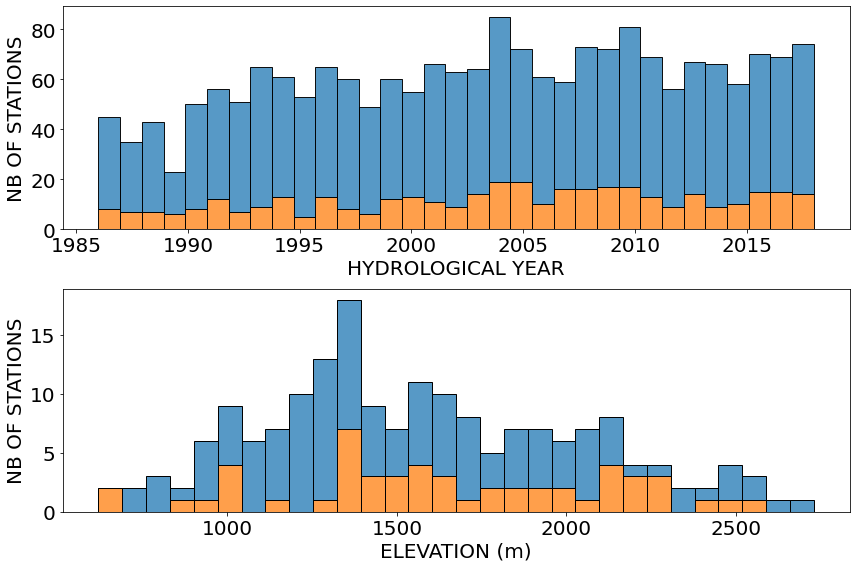

In [8]:
# C.2) STATION USE
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import numpy as np
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  

plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")


df_stations_alt = df[["ALT","ID","MTN"]].drop_duplicates()
df_stations_alt["ALL"] = "ALL"

print(df_stations_alt)

print(df_stations_alt['ALT'].min(),df_stations_alt['ALT'].max())
#sn.reset_orig()
fig, axs = plt.subplots(2)
sn.histplot(ax=axs[1],data = df_stations_alt,x= 'ALT',hue='MTN',hue_order=['ALP','PYR'],multiple='stack',bins=30)
axs[1].set_ylabel("NB OF STATIONS",fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=20)
#axs[0].set_xlabel(None)
axs[1].set_xlabel("ELEVATION (m)",fontsize=20)

#plt.xticks(ticks=[], labels=[])
#plt.yticks(fontsize=20)
axs[1].get_legend().remove()

df_stations_years = df[["HYDRO_YEAR","ID","MTN"]].drop_duplicates()
sn.histplot(ax=axs[0],data = df_stations_years,x="HYDRO_YEAR",hue='MTN',hue_order=['ALP','PYR'],bins=33,multiple='stack')
axs[0].set_ylabel("NB OF STATIONS",fontsize=20)
axs[0].tick_params(axis='both', which='major', labelsize=20)
#axs[0].set_xticks([1986] + list(range(1990,2019,5)),[1986] + list(range(1990,2019,5)),rotation=45) 
#axs[0].set_xlim(1986,2019) 
axs[0].set_xlabel("HYDROLOGICAL YEAR",fontsize=20)
axs[0].get_legend().remove()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.tight_layout()

plt.savefig(os.path.join(plot_path,f'stations_meta.svg'),format="svg")


In [ ]:
# C.3) NOBS DISTRIBUTION BETWEEN MOUNTAIN RANGES
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pickle
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  
    
df_temp =  df.query(" MODEL == 'TB' & MIN_DEPTH == 1 & SMOD > 0   & MAX_SMOD_ΔOBS == 0 & MIN_PREC == 4 & ELEVATION > 900 ")
fig, ax = plt.subplots()
sn.histplot(ax=ax,data=df_temp,x='NOBS',hue="MTN",multiple='stack')
fig.set_figwidth(10)
fig.set_figheight(6)
ax.set_xlabel("NOBS",size=12)
ax.set_ylabel("Nb of data",size=12)
plt.savefig(os.path.join(plot_path,f'NOBSMTN.pdf'),format="pdf",transparent=False,facecolor='white')
print(df_temp.query("NOBS >= 25").groupby("MTN")["SMOD"].count()/df_temp.groupby("MTN")["SMOD"].count())
print(df_temp.groupby("MTN")["SMOD"].count())

In [ ]:
# C.4) SMOD ERROR DISTRIBUTION ACROSS NOBS RANGES
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pickle
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  
    
df_temp =  df.query(" (MODEL == 'TB' | MODEL == 'THEIA') & SMOD > 0  & NOBS < 60 & NOBS >= 10  ").sort_values(by=["NOBS"])
print(df_temp['NOBS'].mean(),df_temp['NOBS'].min(),df_temp['NOBS'].max())
fig, axs = plt.subplots(2,sharex='col')
sn.histplot(data=df_temp,x='NOBS_RANGE',ax=axs[0],color="darkgrey")
sn.boxplot(data=df_temp,y='ΔSMOD',x='NOBS_RANGE',ax=axs[1],showfliers=False,color="darkgrey")
axs[1].tick_params(labelrotation=45)
axs[1].axhline(0, ls='--', color='red')
axs[1].set_xlabel("NOBS")
axs[0].set_ylabel("COUNT")
fig.set_figwidth(10)
fig.set_figheight(6)
plt.savefig(os.path.join(plot_path,f'smodhist.png'),format="png",transparent=False,facecolor='white', dpi=300)

['SWHLX' 'THEIA']
['SWHLX' 'THEIA']


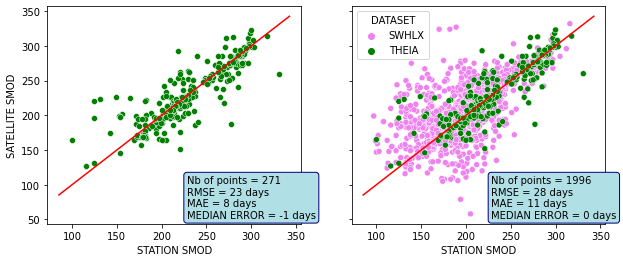

In [18]:
# C.5) SMOD SCATTERPLOTS FOR THE DATASETS SWHLX AND THEIA
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pickle
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  
    
    
fig, axs = plt.subplots(1,2,sharex=True, sharey=True)

df_temp = df.replace("TB", "SWHLX")
df_temp = df_temp.rename(columns={"MODEL": "DATASET"})

df_temp.loc[df_temp['DATASET'] == 'THEIA', 'Top'] = 2
df_temp.loc[df_temp['DATASET'] == 'SWHLX', 'Top'] = 1
df_temp = df_temp.sort_values(by=['Top'], ascending=True) 

print(df_temp.DATASET.unique())

df_temp2 =  df_temp.query("DATASET == 'THEIA' | DATASET == 'SWHLX'")
print(df_temp2.DATASET.unique())

#print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp2['INSITU_SMOD'], df_temp2['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp2['ΔSMOD'])
MAE = median_absolute_error( df_temp2['INSITU_SMOD'], df_temp2['SMOD'] )
nb = df_temp2['INSITU_SMOD'].count()


sn.scatterplot(data=df_temp2, x="INSITU_SMOD", y="SMOD",hue='DATASET',palette = ['violet','green'],ax= axs[1])

x0, x1 = axs[1].get_xlim()
y0, y1 = axs[1].get_ylim()
lims = [max(x0, y0), min(x1, y1)]
axs[1].plot(lims, lims, '-r')

axs[1].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse)} days\nMAE = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs[1].set_xlabel("STATION SMOD")
axs[1].set_ylabel("SATELLITE SMOD")


df_temp1 =  df_temp.query("(DATASET == 'THEIA')")
#print(df_temp)
rmse = np.sqrt( mean_squared_error( df_temp1['INSITU_SMOD'], df_temp1['SMOD'] ))
ΔSMOD_MEDIAN = np.median(df_temp1['ΔSMOD'])
MAE = median_absolute_error( df_temp1['INSITU_SMOD'], df_temp1['SMOD'] )
nb = df_temp1['INSITU_SMOD'].count()

sn.scatterplot(data=df_temp1, x="INSITU_SMOD", y="SMOD",color = 'green',ax= axs[0])

x0, x1 = axs[0].get_xlim()
y0, y1 = axs[0].get_ylim()
#lims = [max(x0, y0), min(x1, y1)]
axs[0].plot(lims, lims, '-r')

axs[0].annotate(f"Nb of points = {nb}\nRMSE = {round(rmse)} days\nMAE = {int(MAE)} days\nMEDIAN ERROR = {int(ΔSMOD_MEDIAN)} days" ,
                    xy=(0.55, 0.12), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})


axs[0].set_xlabel("STATION SMOD")
axs[0].set_ylabel("SATELLITE SMOD")



fig.set_figwidth(10)

plt.savefig(os.path.join(plot_path,f'scatter_SWHLX_Theia.pdf'),format="pdf",transparent=False,facecolor='white')


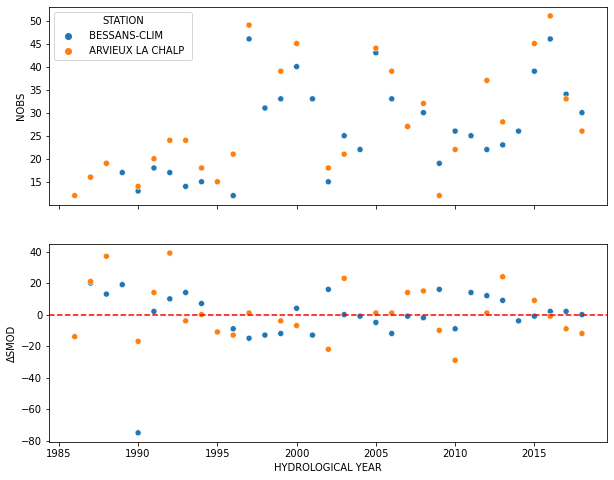

In [8]:
# C.6) SLIDING WINDOW ANALYSIS OF THE SMOD ERROR ACROSS THE HYDRO YEARS
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pickle
import pandas as pd
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  


#sliding window
def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        print(np.median(y))
        ax.axhline(np.median(y), ls='--', color=color)
        

pd.options.mode.chained_assignment = None

df_temp = df.query(f"(MODEL == 'THEIA' | MODEL == 'TB' ) & SCD > 90 & INSITU_SMOD_PREC <= 0 & PERIOD == 'FULL'")

df_temp = df_temp.rename(columns={"NAME": "STATION", "HYDRO_YEAR": "HY"})



window_size = 1
slide_size = 1
list_period=[]
list_df = []
for Y in  range(1986,2019-window_size+1,slide_size):
    df_i= df_temp.query(f" HY >= {Y} & HY < {Y + window_size} ")
    df_i['HY WINDOW'] = f"[{Y};{Y + window_size -1}]"
    list_df.append(df_i)
    list_period.append(f"[{Y};{Y + window_size -1}]")
df_windows = pd.concat(list_df,ignore_index=True)




fig, axs = plt.subplots(2,sharex=True)

sn.scatterplot(data=df_temp.query("NOBS >= 10"), x="HY", y="NOBS",hue="STATION",ax= axs[0],color="orange")
sn.scatterplot(data=df_temp.query("NOBS >= 10"), x="HY", y="ΔSMOD",hue="STATION",ax= axs[1],color="orange",legend=False)

axs[1].axhline(0, ls='--', color='red')
axs[1].set_xlabel('HYDROLOGICAL YEAR')



fig.set_figwidth(10)
fig.set_figheight(8)

plt.savefig(os.path.join(plot_path,f'D_SMOD_10.png'),format="png",transparent=False,facecolor='white')






In [ ]:
# C.7) BUILD SMOD ERROR HISTOGRAM PER ELEVATION RANGES
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pickle
import pandas as pd
import numpy as np
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
df_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_Theia.pkl")
with open( df_path, "rb" )  as dp:
    df = pickle.load(dp)  

def draw_modes(plot,ax):
    for line in plot.get_lines():
        x, y = line.get_data()
        color = line.get_color()
        #print(x[np.argmax(y)])
        ax.axvline(x[np.argmax(y)], ls='--', color=color)

df_temp = df.query(" (MODEL == 'TB' | MODEL == 'THEIA') & MIN_DEPTH == 1 & SMOD > 0 & SCD >= 90  & ELEVATION > 900 & ELEVATION < 2700 ")
df_temp = df_temp.sort_values(by='ELEVATION')
df_temp["ELEVATION"] = df_temp["ELEVATION"].astype(int).astype(str)
print(df_temp.groupby(["MTN","ELEVATION"])["SMOD"].count())


fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="INSITU_SMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis")
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="INSITU_SMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="INSITU_SMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack')
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("SMOD")
axs[1].set_xlabel("SMOD")
axs[2].set_xlabel("SMOD")
plt.suptitle("STATION SMOD",fontsize=15)
sn.move_legend(axs[0], "upper center", ncol=2, title = "ELEVATION (±150 m)")
sn.move_legend(axs[2], "upper center", ncol=2, title = None,labels=['Pyrenees','Alps'])
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(os.path.join(plot_path,f'smodgkde_station.pdf'),format="pdf",transparent=False,facecolor='white')


fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="SMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="SMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="SMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack',legend=False)
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("SMOD")
axs[1].set_xlabel("SMOD")
axs[2].set_xlabel("SMOD")
plt.suptitle("SATELLITE SMOD",fontsize=15)
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(os.path.join(plot_path,f'smodgkde_satellite.pdf'),format="pdf",transparent=False,facecolor='white')



fig, axs = plt.subplots(1,3,sharex='row',sharey="all")
axs[0].axvline(0, ls='--', color='red')
axs[1].axvline(0, ls='--', color='red')
axs[2].axvline(0, ls='--', color='red')
axs[2].set_xbound(-100,100)
stations_kde = sn.histplot(ax=axs[0],data = df_temp.query("MTN == 'PYR'"),x="ΔSMOD",hue='ELEVATION',stat = 'density',bins=30, common_norm = True,multiple='stack',palette="viridis",legend=False)
stations_kde = sn.histplot(ax=axs[1],data = df_temp.query("MTN == 'ALP'"),x="ΔSMOD",hue='ELEVATION',stat = 'density',bins=30,common_norm = True,multiple='stack',palette="viridis")
stations_kde = sn.histplot(ax=axs[2],data = df_temp,x="ΔSMOD",hue='MTN',hue_order=["ALP","PYR"],stat = 'density',bins=30,common_norm = True,multiple='stack')
axs[0].set_title("PYR")
axs[1].set_title("ALP")
axs[2].set_title("ALL")
axs[0].set_xlabel("ΔSMOD")
axs[1].set_xlabel("ΔSMOD")
axs[2].set_xlabel("ΔSMOD")
plt.suptitle("RESIDUALS (ΔSMOD)",fontsize=15)
fig.set_figwidth(10)
fig.tight_layout()
plt.savefig(os.path.join(plot_path,f'smodgkde_diff.pdf'),format="pdf",transparent=False,facecolor='white')


In [ ]:
#D) MAKING AND ANALYSING SMOD TRENDS

In [ ]:
# D.1) YEARLY SMOD MEDIANS PER SAFRAN MASSIFS

In [ ]:
# D.1.1) GENERATE YEARLY SMOD MEDIANS PER SAFRAN MASSIFS
import os

SAFRAN_tiles={
    "ALP":
    {
        "Chablais","Mont-Blanc","Haute-Tarentaise","Haute-Maurienne","Chartreuse","Aravis","Beaufortain","Vanoise","Maurienne","Bauges",
        "Grandes-Rousses","Belledonne","Vercors","Oisans","Devoluy","Champsaur","Pelvoux","Embrunnais Parpaillon","Ubaye","Queyras",
        "Thabor","Haut-Var Haut-Verdon","Mercantour"
    },
    "PYR":
    {
        "Pays-Basque","Aspe Ossau","Haute-Bigorre","Aure Louron","Luchonnais","Couserans","Haute-Ariege","Orlu St-Barthelemy",
        "Capcir Puymorens","Cerdagne Canigou","Andorre","Navarra","Jacetiana","Gallego","Sobrarbe","Esera","Aran","Ribagorcana",
        "Pallaresa","Perafita","Ter-Freser"
    }
}

model = "TCD-BLUE_AVG-1200"
account = "" #trex account
log_path = os.path.join(project_dir,"CODE","logs")
job_sh_path = os.path.join(project_dir,"CODE","safran_median_aspect_MK.sh")
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=06:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)

for mtn in SAFRAN_tiles:
    for i,massif in enumerate(SAFRAN_tiles[mtn]):

        jobname=f"{mtn}_{i}_MK"
        export =  ",".join([ f"MTN=\"{mtn}\",MASSIF=\"{massif}\",N=\"{i}\",project_dir=\"{project_dir}\",model=\"{model}\""])
        os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
        
                

In [5]:
# D.1.2) CONCATENATE DATAFRAMES FROM D.1.1
import glob
import os
import pickle
import pandas as pd
list_df = glob.glob(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","swhlx_theia_safran_median_aspect_hydro_rgi_*.pkl"))

with open( list_df[0], "rb" )  as dp:
    df = pickle.load(dp) 
for l in list_df[1:]:
    with open( l, "rb" )  as dp:
        df2 = pickle.load(dp) 
    df = pd.concat([df,df2],ignore_index=True)
df.to_pickle(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK.pkl"))


     MIN_NOBS  HYDRO_YEAR  Nb of data
0           2        1986         246
9           4        1986         246
18          6        1986         246
27          8        1986         245
36         10        1986         243
45         12        1986         233
54         14        1986         225
63         16        1986         190
72         18        1986         172
81         20        1986         153
90         22        1986         129
99         24        1986          80
108        26        1986          30


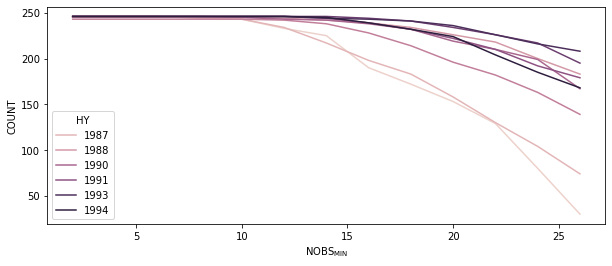

In [37]:
# D.1.3) GET NB OF AVAILABLE SMOD MEDIANS FROM COMBINATIONS OF MASSIFS AND ELEVATION BANDS
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
df_temp = df.query("TOPO == 'NONE' ").sort_values(by="MIN_NOBS")

df_count = df_temp.query(f" PIXEL_COUNT >= 1000 & HYDRO_YEAR < 1995").groupby(["MIN_NOBS","HYDRO_YEAR"])["SMOD_MEDIAN"].count().to_frame("Nb of data").reset_index()
print(df_count.query("HYDRO_YEAR == 1986"))
df_count = df_count.rename(columns={"HYDRO_YEAR":"HYDRO YEAR"})

fig, ax = plt.subplots()
sn.lineplot(ax=ax,data=df_count,x="MIN_NOBS",y="Nb of data",hue="HYDRO YEAR")
plt.rcParams.update({'mathtext.default':  'regular' })
ax.set_xlabel("NOBS$_{MIN}$")
ax.set_ylabel("COUNT")
ax.legend(title="HY")
fig.set_figwidth(10)
fig.set_figheight(4)
plt.savefig(os.path.join(plot_path,f'NOBSMIN.png'),format="png",transparent=False,facecolor='white', dpi=300)

In [ ]:
# D.1.4) CHECK FOR AUTOCORRELATION
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import numpy as np


with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
df_mask = df.query("TOPO == 'NONE' & MIN_NOBS == 10")
print(df_mask)
df_mask.loc[(df_mask.PIXEL_COUNT < 1000),'SMOD_MEDIAN']=np.nan
for massif in df_mask.SAFRAN.unique():
    ele_list = df_mask.query(f"SAFRAN == '{massif}'").ELEVATION.unique()
    nb_ele = len(ele_list)
    fig, axs = plt.subplots(1,nb_ele,figsize=(25,2),sharey=True)
    df_msf = df_mask.query(f"SAFRAN == '{massif}'")
    fig.suptitle(massif)
    for i,ele in enumerate(ele_list):
        data = df_msf.query(f"ELEVATION == {ele}").set_index('HYDRO_YEAR').SMOD_MEDIAN.tolist()
        if not np.isnan(data).any():
            sm.graphics.tsa.plot_acf(data, lags=20, ax=axs[i],alpha=.05)
            axs[i].set_title(ele, y=1.0,pad=-14)
            axs[i].axhline(y=0.5,xmin=0,xmax=20,c="red",linewidth=0.5,zorder=0)
            axs[i].axhline(y=-0.5,xmin=0,xmax=20,c="red",linewidth=0.5,zorder=0)



In [13]:
# D.1.5) MANNKENDALL TEST OF SMOD TRENDS FOR EVERY 20 YEARS PERIOD OR MORE PER MASSIF

import pymannkendall as mk
import pandas as pd
import pickle
notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out

with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 

min_px_count = 1000

df = df.query(f"TOPO == 'NONE' & ELEVATION > 1200 & (MIN_NOBS == 26) ")
print(df)
df.loc[(df.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan


list_df = []

for start_year in range(1986,2004):
    
    for end_year in range(start_year + 19,2023):
        print(start_year,end_year,end="           \r")
        
        c = end_year - start_year +1
        
        df_period = df.sort_values(by=["HYDRO_YEAR"]).query(f"HYDRO_YEAR >= {start_year} & HYDRO_YEAR <= {end_year}").groupby(["MTN","ELEVATION","SAFRAN","MIN_NOBS"]).apply(mannkendall,sy=start_year,ey=end_year)
        
        df_period = df_period.reset_index()
        df_period["START_YEAR"] = int(start_year)
        df_period["END_YEAR"] = int(end_year)
        list_df.append(df_period)
        

df_mk = pd.concat(list_df,ignore_index=True)    
df_mk["slope"] = df_mk["slope"] * 10

df_mk.to_pickle(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK_PERIODS20PLUS.pkl"))
   

         ELEVATION        SAFRAN  MTN  SMOD_MEDIAN  SOD_MEDIAN  SCD_MEDIAN  \
120           1500       Pelvoux  ALP        181.0       106.0        76.0   
250           1800       Pelvoux  ALP        150.0       106.0        88.0   
380           2100       Pelvoux  ALP        269.0        38.0       252.0   
510           2400       Pelvoux  ALP        269.0        38.0       232.0   
640           2700       Pelvoux  ALP        289.0        38.0       252.0   
...            ...           ...  ...          ...         ...         ...   
2327510       3300  Haute-Ariege  PYR          NaN         NaN         NaN   
2327640       3600  Haute-Ariege  PYR          NaN         NaN         NaN   
2327770       3900  Haute-Ariege  PYR          NaN         NaN         NaN   
2327900       4200  Haute-Ariege  PYR          NaN         NaN         NaN   
2328030       4500  Haute-Ariege  PYR          NaN         NaN         NaN   

         PIXEL_COUNT  MIN_NOBS  TOPO  TOPO_VALUE  HYDRO_YEAR DA

In [ ]:
# D.1.6) HEATMAPS OF SMOD TRENDS + SIGNIFICANT P-VALUES FOR EVERY 20 YEARS PERIOD OR MORE PER MASSIF

import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

SAFRAN_tiles={
    "ALP":
    {
        "Chablais","Mont-Blanc","Haute-Tarentaise","Haute-Maurienne","Chartreuse","Aravis","Beaufortain","Vanoise","Maurienne","Bauges",
        "Grandes-Rousses","Belledonne","Vercors","Oisans","Devoluy","Champsaur","Pelvoux","Embrunnais Parpaillon","Ubaye","Queyras",
        "Thabor","Haut-Var Haut-Verdon","Mercantour"
    },
    "PYR":
    {
        "Pays-Basque","Aspe Ossau","Haute-Bigorre","Aure Louron","Luchonnais","Couserans","Haute-Ariege","Orlu St-Barthelemy",
        "Capcir Puymorens","Cerdagne Canigou","Andorre","Navarra","Jacetiana","Gallego","Sobrarbe","Esera","Aran","Ribagorcana",
        "Pallaresa","Perafita","Ter-Freser"
    }
}



plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK_PERIODS20PLUS.pkl"), "rb" )  as dp:
    df_mk = pickle.load(dp) 


print(df_mk)
df_mk_nan = df_mk.copy()
notna_var = pd.notna
df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))

bar_min = -25#df_mk["slope"].values.min()
bar_max = 25#df_mk["slope"].values.max()
ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25]         


for mtn in SAFRAN_tiles:
    for massif in SAFRAN_tiles[mtn]:

        for min_obs in range(18,19):
            list_ele = df_mk.query(f"SAFRAN == '{massif}' & @notna_var(slope)")["ELEVATION"].unique()
            if len(list_ele) == 0: continue
            fig, axs = plt.subplots(int(ceil(len(list_ele)/2)),2)
            cbar_ax = fig.add_axes([.91, .3, .03, .4])

            x= 0
            y=0

            for i , elevation in enumerate(list_ele):

                x = i%2 
                
                df_heat = df_mk.query(f"SAFRAN == '{massif}'  & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
                df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
                df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="annot")
                df_annot = df_annot.fillna(32).astype('int')

                if len(list_ele) > 2:
                    axis = axs[y,x]
                else:
                    axis = axs[x]
                sn.heatmap(df_heat,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
                sn.heatmap(df_heat_nan,ax=axis,cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 20,"weight": "bold"},cbar_kws={'ticks': ticks})
                axis.collections[0].colorbar.set_ticklabels([t for t in ticks])
                axis.grid()
                axis.set_title(f"elevation: {elevation} m",size=20)
                axis.xaxis.set_tick_params(labelsize=12)
                axis.yaxis.set_tick_params(labelsize=12)
                axis.invert_yaxis() 

                axis.set(xlabel=None,ylabel=None)
                axis.set_axisbelow(True)
                #fig.colorbar(im, cax=cbar_ax)
                y = y + i%2
            if len(list_ele) %2:
                fig.delaxes(axs[y][1])
            fig.suptitle(f"{massif} SMOD trends (days per decade)",size=20,y=0.93)
            fig.set_figwidth(10)
            fig.set_figheight(15)
            plt.subplots_adjust(hspace=0.7)
            plt.subplots_adjust(wspace=0.3)
            fig.supxlabel('START YEAR',y=0.04,size=20)
            fig.supylabel('END YEAR',size=20)


            plt.savefig(os.path.join(plot_path,f'{mtn}_{massif.replace(" ", "_")}_MINNOBS_{min_obs}_periods.pdf'),format="pdf",transparent=False,facecolor='white')


    

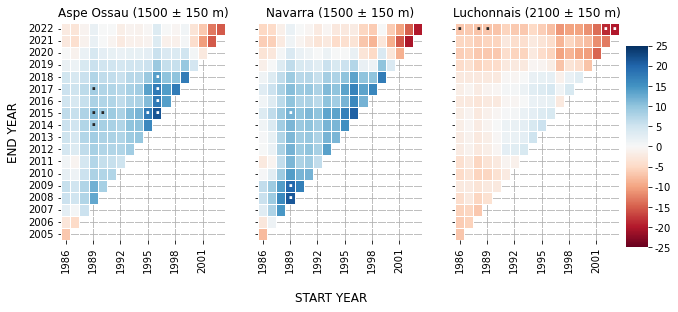

In [27]:
# D.1.7) HEATMAPS FOR COMPARISON WITH RESULTS FROM Lopez-Moreno et al 2020  https://doi.org/10.1002/joc.6571
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_ALL_MK_PERIODS20PLUS.pkl"), "rb" )  as dp:
    df_mk = pickle.load(dp) 

df_mk_nan = df_mk.copy()
notna_var = pd.notna
df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))

bar_min = -25#df_mk["slope"].values.min()
bar_max = 25#df_mk["slope"].values.max()
ticks=[-25,-20,-15,-10,-5,0,5,10,15,20,25]         
min_obs = 26
fig, axs = plt.subplots(1,3,sharey=True)
cbar_ax = fig.add_axes([.91, 0.1, .03, .7])

x =0

for massif,elevation in [('Aspe Ossau',1500),('Navarra',1500), ('Luchonnais',2100)]:

    df_heat = df_mk.query(f"SAFRAN == '{massif}'  & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
    df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="slope")
    df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION == {elevation} & MIN_NOBS == {min_obs}").pivot(index="END_YEAR", columns="START_YEAR", values="annot")
    df_annot = df_annot.fillna(32).astype('int')

    sn.heatmap(df_heat,ax=axs[x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
    sn.heatmap(df_heat_nan,ax=axs[x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"},cbar_kws={'ticks': ticks})
    axs[x].collections[0].colorbar.set_ticklabels([t for t in ticks])
    axs[x].grid()
    axs[x].set_title(f"{massif} ({elevation} ± 150 m)")
    axs[x].invert_yaxis() 


    axs[x].set(xlabel=None,ylabel=None)
    axs[x].set_axisbelow(True)
    #fig.colorbar(im, cax=cbar_ax)
    x = x+1

fig.set_figwidth(10)
#fig.set_figheight(10)
plt.subplots_adjust(hspace=0.7)
#plt.subplots_adjust(wspace=0.3)
fig.supxlabel('START YEAR',y=-0.1)
fig.supylabel('END YEAR',x=0.05)


plt.savefig(os.path.join(plot_path,f'comparison_moreno.pdf'),format="pdf",transparent=False,facecolor='white')


    

      MTN  ELEVATION      SAFRAN  TOPO_VALUE      p     slope  COUNT_YEAR
0     ALP       1500      Aravis         0.0  False -3.100962        37.0
1     ALP       1500      Aravis        90.0  False -5.000000        37.0
2     ALP       1500      Aravis       180.0  False -6.485294        37.0
3     ALP       1500      Aravis       270.0   True -6.220238        37.0
4     ALP       1500      Bauges         0.0  False       NaN         NaN
...   ...        ...         ...         ...    ...       ...         ...
1931  PYR       4500    Sobrarbe       270.0  False       NaN         NaN
1932  PYR       4500  Ter-Freser         0.0  False       NaN         NaN
1933  PYR       4500  Ter-Freser        90.0  False       NaN         NaN
1934  PYR       4500  Ter-Freser       180.0  False       NaN         NaN
1935  PYR       4500  Ter-Freser       270.0  False       NaN         NaN

[1936 rows x 7 columns]


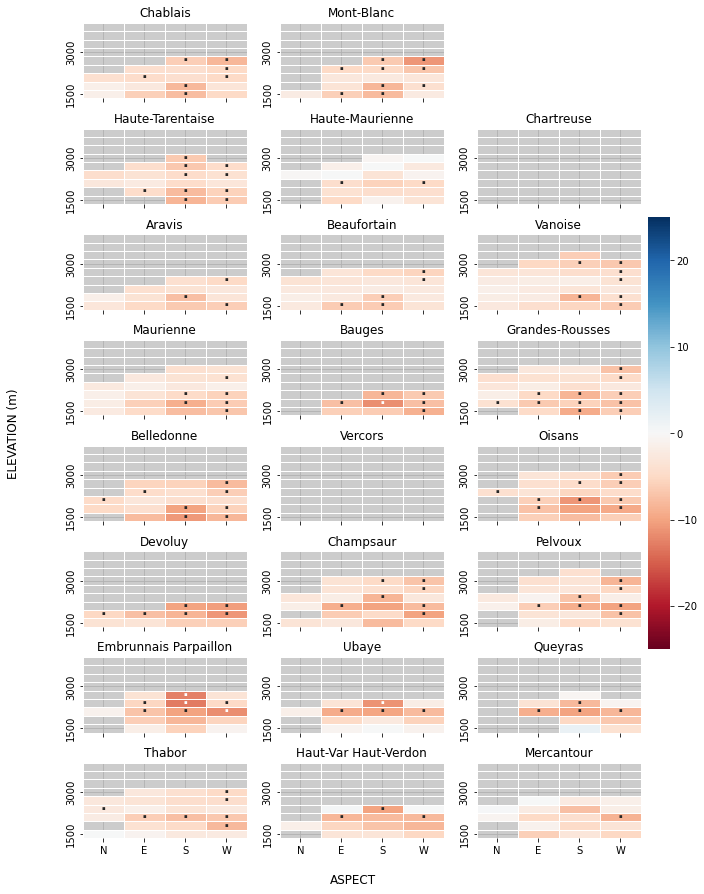

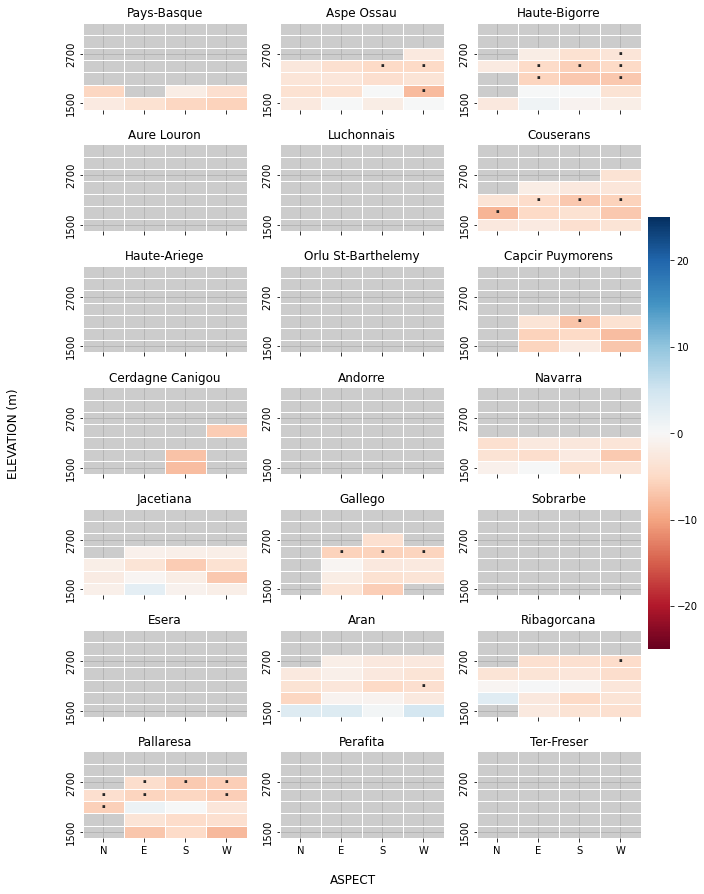

In [11]:
# D.1.8) HEATMAPS OF SMOD TRENDS PER ASPECTS AND ELEVATION
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pymannkendall as mk
import pandas as pd

notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out


plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
    df = df.query("ELEVATION > 1200")



topo="ASPECT"
max_count_year = 30 
min_px_count = 1000
start_year=1986

for min_nobs in range(18,19):

    df_temp =df.query(f"HYDRO_YEAR >= {start_year} & MIN_NOBS == {min_nobs} & TOPO == '{topo}' ")
    df_temp.loc[(df_temp.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan
    df_mk = df_temp.sort_values(by=['HYDRO_YEAR']).groupby(["MTN","ELEVATION","SAFRAN","TOPO_VALUE"]).apply(mannkendall,sy=start_year,ey=2022).reset_index()
    df_mk["slope"] = df_mk["slope"]*10
    print(df_mk)

    df_mk_nan = df_mk.copy()
    notna_var = pd.notna
    df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
    df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))
    bar_min = -25
    bar_max = 25
    mtn = "ALP"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(8,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    skipx=0


    for i,massif in enumerate(list_massifs):
        if i == 2:
            skipx = 1
        x = (i+skipx)%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["N","E","S","W"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=0) 
        axs[y,x].set(xlabel=None,ylabel=None)


        if x == 2 or i == 1:
            y = y + 1 

    fig.delaxes(axs[0][2])
    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('ASPECT',y=0.08)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(os.path.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_4_ASPECT.pdf'),format="pdf",transparent=False,facecolor='white')  

    mtn = "PYR"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(7,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i,massif in enumerate(list_massifs):

        x = i%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300  ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["N","E","S","W"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=0) 
        axs[y,x].set(xlabel=None,ylabel=None)


        if x == 2 :
            y = y + 1 


    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('ASPECT',y=0.08)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(os.path.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_4_ASPECT.pdf'),format="pdf",transparent=False,facecolor='white')   


      ELEVATION     SAFRAN  MTN  SMOD_MEDIAN  PIXEL_COUNT  PIXEL_RATIO  \
0          2100  Champsaur  ALP        269.0        17300         26.0   
1          2100  Champsaur  ALP        268.0        58727         90.0   
2          2100  Champsaur  ALP        274.0        63844         98.0   
3          2100  Champsaur  ALP        256.0        60859         93.0   
4          2100  Champsaur  ALP        268.0        54039         83.0   
...         ...        ...  ...          ...          ...          ...   
1490       2100  Couserans  PYR        249.0        54017         98.0   
1491       2100  Couserans  PYR        212.0        54722         99.0   
1492       2100  Couserans  PYR        231.0        54742         99.0   
1493       2100  Couserans  PYR        255.0        54744        100.0   
1494       2100  Couserans  PYR        252.0        54544         99.0   

      PIXEL_RATIO_SNOW  MIN_NOBS TOPO  TOPO_VALUE  HYDRO_YEAR DATASET  
0                 26.0        20  DAH  

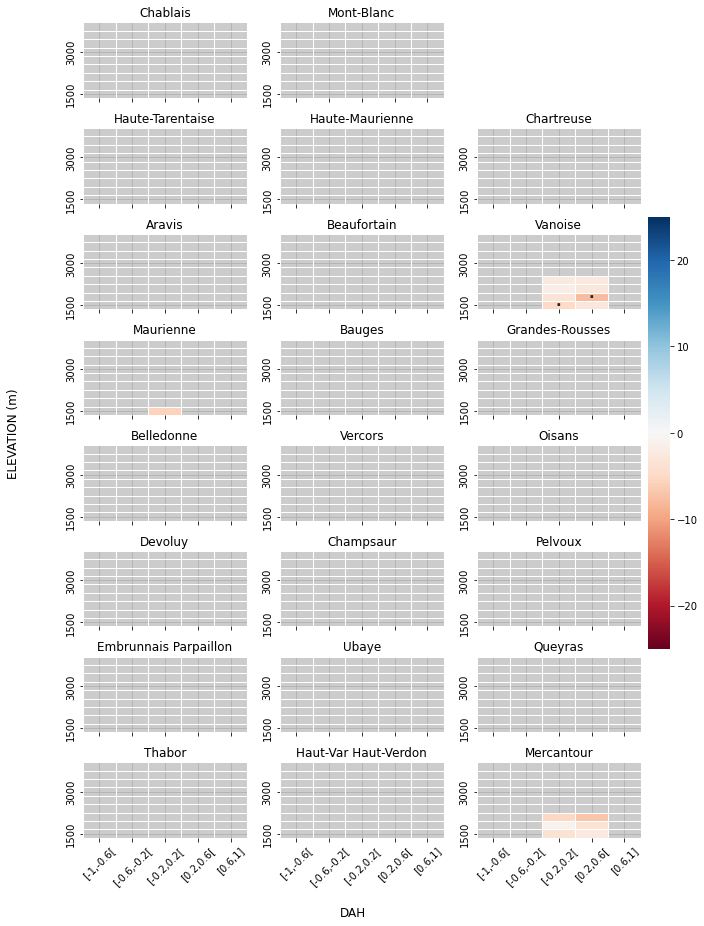

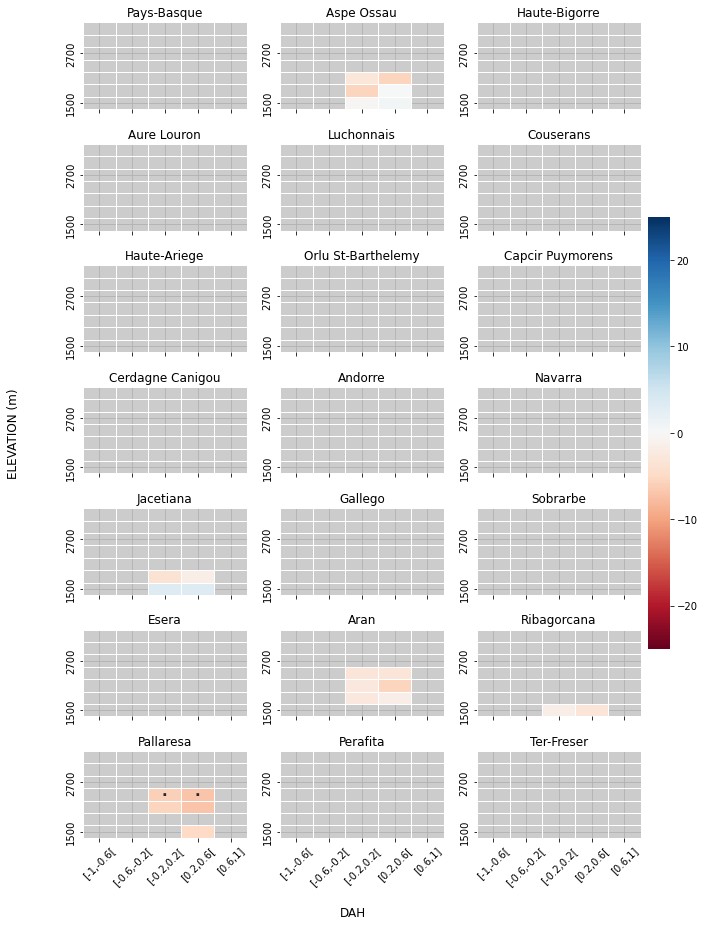

In [14]:
# D.1.9) HEATMAPS OF SMOD TRENDS PER DAH AND ELEVATION
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pymannkendall as mk
import pandas as pd

notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.min() == sy and \
       g.query("@notna_var(SMOD_MEDIAN)").HYDRO_YEAR.max() == ey and \
       g["SMOD_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g.SMOD_MEDIAN, alpha=0.05)
        out = pd.Series( dict(  p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out


plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
    df = df.query("ELEVATION > 1200")




topo="DAH"
max_count_year = 30 
min_px_count = 1000
start_year=1986



    
for min_nobs in range(26,27):

    df_temp =df.query(f"HYDRO_YEAR >= {start_year} & MIN_NOBS == {min_nobs} & TOPO == '{topo}' ")
    df_temp.loc[(df_temp.PIXEL_COUNT < min_px_count)  ,'SMOD_MEDIAN']=np.nan
    df_mk = df_temp.sort_values(by=['HYDRO_YEAR']).groupby(["MTN","ELEVATION","SAFRAN","TOPO_VALUE"]).apply(mannkendall,sy=start_year,ey=2022).reset_index()
    df_mk["slope"] = df_mk["slope"]*10
    print(df_mk)



    df_mk_nan = df_mk.copy()
    notna_var = pd.notna
    df_mk_nan["slope"] = np.where((df_mk_nan["p"] == False),np.nan,df_mk_nan["slope"])
    df_mk_nan["annot"] = np.where((df_mk_nan["p"] == False) ,int(32),int(8901))
    bar_min = -25
    bar_max = 25
    mtn = "ALP"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(8,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    skipx=0


    for i,massif in enumerate(list_massifs):
        if i == 2:
            skipx = 1
        x = (i+skipx)%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}' & ELEVATION <= 3900").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["[-1,-0.6[","[-0.6,-0.2[","[-0.2,0.2[","[0.2,0.6[","[0.6,1]"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=45) 
        axs[y,x].set(xlabel=None,ylabel=None)

        if x == 2 or i == 1:
            y = y + 1 

    fig.delaxes(axs[0][2])
    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('DAH',y=0.05)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(os.path.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_5_DAH.png'),format="png",transparent=False,facecolor='white')  

    mtn = "PYR"
    x= 0
    y=0
    list_massifs = SAFRAN_tiles_2[mtn]
    fig, axs = plt.subplots(7,3, sharex=True,)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for i,massif in enumerate(list_massifs):

        x = i%3
        df_heat = df_mk.query(f"SAFRAN == '{massif}' & ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_heat_nan = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300  ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="slope")
        df_annot = df_mk_nan.query(f"SAFRAN == '{massif}'& ELEVATION <= 3300 ").pivot(index="ELEVATION", columns="TOPO_VALUE", values="annot")
        df_annot = df_annot.fillna(32).astype('int')
        sn.heatmap(df_heat,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,center=0)
        sn.heatmap(df_heat_nan,ax=axs[y,x],cmap='RdBu',vmin=bar_min, vmax=bar_max,cbar_ax = cbar_ax,linewidth=.5,annot=df_annot, fmt="c",center=0,annot_kws={"size": 15,"weight": "bold"})

        axs[y,x].set_title(massif) 
        axs[y,x].grid()
        axs[y,x].invert_yaxis() 
        axs[y,x].set_facecolor('0.8') 
        axs[y,x].set_axisbelow(True)
        axs[y,x].set_xticklabels(["[-1,-0.6[","[-0.6,-0.2[","[-0.2,0.2[","[0.2,0.6[","[0.6,1]"])
        axs[y,x].set_yticklabels(axs[y,x].get_yticklabels(),rotation=90) 
        axs[y,x].set_xticklabels(axs[y,x].get_xticklabels(),rotation=45) 
        axs[y,x].set(xlabel=None,ylabel=None)

        if x == 2 :
            y = y + 1 

    plt.subplots_adjust(hspace=0.4)
    fig.set_figwidth(10)
    fig.set_figheight(15)
    fig.supxlabel('DAH',y=0.05)
    fig.supylabel('ELEVATION (m)')
    plt.savefig(os.path.join(plot_path,f'{mtn}_MINNOBS_{min_nobs}_5_DAH.png'),format="png",transparent=False,facecolor='white')   


In [7]:
# D.1.10) WRITE SHAPEFILE TO MAP THE TRENDS ACROSS THE MASSIFS
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pymannkendall as mk
import pandas as pd
import geopandas as gpd
from osgeo import osr, ogr, gdal

metric='SMOD'
notna_var = pd.notna
def mannkendall(g,sy,ey):
    if g.query(f"@notna_var({metric}_MEDIAN)").HYDRO_YEAR.min() == 1986 and \
       g.query(f"@notna_var({metric}_MEDIAN)").HYDRO_YEAR.max() == 2022 and \
       g[f"{metric}_MEDIAN"].count() >= (ey - sy + 1)*95/100:
        mk_test = mk.original_test(g[f"{metric}_MEDIAN"], alpha=0.05)
        out = pd.Series( dict(  trend = mk_test.trend, p = mk_test.p < 0.05 , slope = mk_test.slope, COUNT_YEAR = g.HYDRO_YEAR.count()) )
    else:
        out = pd.Series( dict(  trend = 'nan', p = False , slope = np.nan, COUNT_YEAR = np.nan) )
    return out

with open(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","SWHLX_THEIA_MK.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
SAFRAN_PATH = os.path.join(project_dir,"DATA","SAFRAN","massifs_WGS84.shp")
out_path = os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","SHP",metric+"_SWHLX_THEIA_MK_NOBS12_HYDRO_RGI.shp")


df.loc[(df.PIXEL_COUNT < 1000)  ,f'{metric}_MEDIAN']=np.nan
df_MK2 = df.sort_values(by=["HYDRO_YEAR"]).query(f"MIN_NOBS == 12  & ELEVATION > 1200 & TOPO == 'NONE'").groupby(["MTN","ELEVATION","SAFRAN"]).apply(mannkendall,sy=1986,ey=2022).reset_index()
df_MK2['slope'] = df_MK2['slope']*10

drv = ogr.GetDriverByName( 'ESRI Shapefile' )
shapefile = gpd.read_file(SAFRAN_PATH)

list_ele = df_MK2.ELEVATION.unique()
list_massifs = df_MK2.SAFRAN.unique()

for ele in list_ele:
    print(ele)
    att_name = metric+"_"+str(ele)
    p_name = "p_"+str(ele)

    df2= df_MK2.query(f"ELEVATION == {ele}")
    list_val = []
    list_p = []
    for ind in shapefile.index:
        massif = shapefile['title'][ind]
        val = np.nan
        trend_val = np.nan
        if massif in df2['SAFRAN'].unique():
            trend_val = df2.loc[df2['SAFRAN'] == massif, 'trend'].values[0]
            if trend_val == "no trend":
                val = df2.loc[df2['SAFRAN'] == massif, 'slope'].values[0]
            if trend_val == "nan":
                val = np.nan
            if trend_val == "decreasing" or trend_val == "increasing":
                val = df2.loc[df2['SAFRAN'] == massif, 'slope'].values[0]
        list_val.append(val)
        list_p.append(trend_val)
    shapefile[att_name] = list_val
    shapefile[p_name] = list_p
shapefile.to_file(out_path)
    



         ELEVATION        SAFRAN  MTN  SMOD_MEDIAN  SOD_MEDIAN  SCD_MEDIAN  \
0             1500       Pelvoux  ALP        181.0       106.0        76.0   
1             1500       Pelvoux  ALP        225.0        90.0       144.0   
2             1500       Pelvoux  ALP        189.0       106.0        92.0   
3             1500       Pelvoux  ALP        181.0       106.0        74.0   
4             1500       Pelvoux  ALP        189.0       108.0        90.0   
...            ...           ...  ...          ...         ...         ...   
2328035       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328036       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328037       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328038       4500  Haute-Ariege  PYR          NaN         NaN         NaN   
2328039       4500  Haute-Ariege  PYR          NaN         NaN         NaN   

         PIXEL_COUNT  MIN_NOBS    TOPO  TOPO_VALUE  HYDRO_YEAR 

In [ ]:
# D.2) YEARLY SMOD PER PIXEL

In [ ]:
# D.2.1) MAKE TREND DATAFRAMES OF MK TEST AND SEN SLOPE FOR EACH PIXEL
import os

SAFRAN_tiles={
    "ALP":
    {
        "Chablais","Mont-Blanc","Haute-Tarentaise","Haute-Maurienne","Chartreuse","Aravis","Beaufortain","Vanoise","Maurienne","Bauges",
        "Grandes-Rousses","Belledonne","Vercors","Oisans","Devoluy","Champsaur","Pelvoux","Embrunnais Parpaillon","Ubaye","Queyras",
        "Thabor","Haut-Var Haut-Verdon","Mercantour"
    },
    "PYR":
    {
        "Pays-Basque","Aspe Ossau","Haute-Bigorre","Aure Louron","Luchonnais","Couserans","Haute-Ariege","Orlu St-Barthelemy",
        "Capcir Puymorens","Cerdagne Canigou","Andorre","Navarra","Jacetiana","Gallego","Sobrarbe","Esera","Aran","Ribagorcana",
        "Pallaresa","Perafita","Ter-Freser"
    }
}

account = "" #trex account
log_path = os.path.join(project_dir,"CODE","logs")
job_sh_path = os.path.join(project_dir,"CODE","safran_pixel_MK.sh")
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=01:59:59",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)

DTM_step = 300
DTM_min = 1500
DTM_max= 4500
model = "TCD-BLUE_AVG-1200"

for mtn in SAFRAN_tiles_2:
    for i,massif in enumerate(SAFRAN_tiles[mtn]):
        for ele in range(DTM_min,DTM_max+1,DTM_step):
            jobname=f"{mtn}_{i}_{ele}_MK"
            export =  ",".join([ f"MTN=\"{mtn}\",MASSIF=\"{massif}\",N=\"{i}\",ELE=\"{ele}\",project_dir=\"{project_dir}\",model=\"{model}\""])
            os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  
            

In [8]:
# D.2.2) CONCATENATE ALL DATAFRAMES FROM D.2.1
import glob
import os
import pickle
import pandas as pd

list_df = glob.glob(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","safran_pixel_*.pkl"))
len_list = len(list_df)
with open( list_df[0], "rb" )  as dp:
    print(f"1/{len_list}",end= "               \r")
    df = pickle.load(dp)
df = df[["ELEVATION","MTN","SLOPE","TREND","MIN_NOBS"]].query("MIN_NOBS == 10")
for i,l in enumerate(list_df[1:],2):
    print(f"{i}/{len_list}",end= "               \r")
    with open( l, "rb" )  as dp:
        df2 = pickle.load(dp) 
    df = pd.concat([df,df2[["ELEVATION","MTN","SLOPE","TREND","MIN_NOBS"]].query("MIN_NOBS == 10")],ignore_index=True)
df.to_pickle(os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","PIXEL_MK_MULTI_NOBS.pkl"))
print(df)

          ELEVATION  MTN  SLOPE TREND  MIN_NOBS
0            3600.0  ALP    NaN   nan      10.0
1            3600.0  ALP    NaN   nan      10.0
2            3600.0  ALP    NaN   nan      10.0
3            3600.0  ALP    NaN   nan      10.0
4            3600.0  ALP    NaN   nan      10.0
...             ...  ...    ...   ...       ...
26260882     3000.0  PYR    NaN   nan      10.0
26260883     3000.0  PYR    NaN   nan      10.0
26260884     3000.0  PYR    NaN   nan      10.0
26260885     3000.0  PYR    NaN   nan      10.0
26260886     3000.0  PYR    NaN   nan      10.0

[26260887 rows x 5 columns]


In [14]:
# D.2.3) GET MEAN AND STD OF PIXEL SMOD TRENDS
import os
import pickle
import pandas as pd

with open( os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","PIXEL_MK_MULTI_NOBS.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
df = df[["ELEVATION","SLOPE","TREND","MTN"]]
df = df.query("SLOPE.notnull()",engine='python')
df["SLOPE"] = df["SLOPE"]*37
print(df.groupby(["MTN"])["SLOPE"].mean())
print(df.groupby(["MTN"])["SLOPE"].std())

prepare dataframes


/tmp/slurm-17978411/ipykernel_279189/3649612624.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp2["Significance"] ="p < 0.05"


start plots
boxplot
histplot
[[1107670 2883926 4040682 3627324 1063985   80208]
 [  51854  391805  702626  686210  237988   17512]] [[-0.5  0.5  1.5  2.5  3.5  4.5]
 [-0.5  0.5  1.5  2.5  3.5  4.5]]
[ 4.68135817 13.58582016 17.38879724 18.91780277 22.36760857 21.83323359]


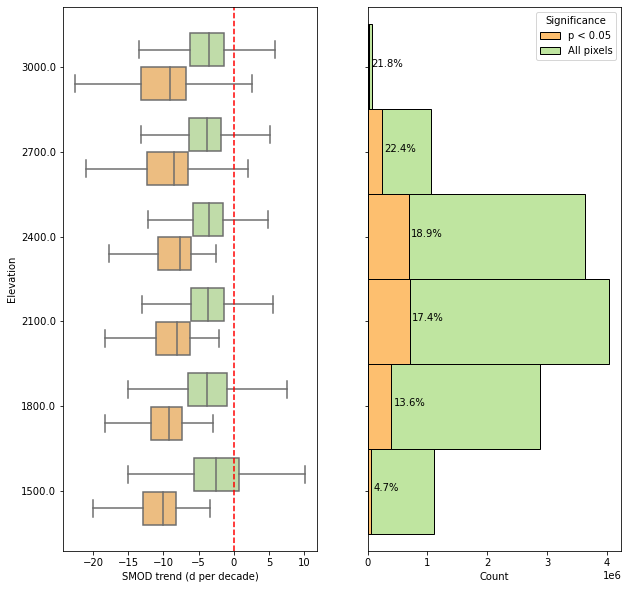

In [13]:
# D.2.4) MAKE BOXPLOT PER ELEVATION RANGE FOR THE PYRENEES
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pymannkendall as mk
import pandas as pd


def draw_text(plot,ax):
    w = []
    y = []
    for i,patch in enumerate(plot.patches):
        w.append(plot.patches[i].get_width())
        y.append(plot.patches[i].get_y())
    w = np.array(w).reshape(2, int(len(w)/2))
    y = np.array(y).reshape(2, int(len(y)/2))
    print(w,y)
    p = w[1]/w[0]*100
    print(p)
    for i in range(len(p)):
        plot.annotate("{:.1f}%".format(p[i]), xy=(w[1][i] + 40000 ,y[0][i] + 0.5))
        
with open( os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","PIXEL_MK_MULTI_NOBS.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
        
mtn = 'PYR'
print("prepare dataframes")

df_temp = df.sort_values(by=['ELEVATION']).query(f"ELEVATION <= 3000 & MTN == '{mtn}'")
df_temp = df_temp.rename(columns={"SIGNIFICANCE": "Significance"})
df_temp2 = df_temp.query("TREND != 'no trend'")
df_temp["Significance"] ="All pixels"
df_temp2["Significance"] ="p < 0.05"

df_temp = pd.concat([df_temp,df_temp2],ignore_index=True)

df_temp['ELEVATION'] = df_temp['ELEVATION'].astype(str)


hur_order=["p < 0.05","All pixels"]

print("start plots")
fig, axs = plt.subplots(1,2,sharey=True)
print("boxplot")
bp = sn.boxplot(ax=axs[0],data=df_temp,y="ELEVATION",x="SLOPE",hue="Significance",hue_order=hur_order, showfliers=False,palette='Spectral')
axs[0].invert_yaxis() 
axs[0].axvline(0, ls='--', color='red')
axs[0].legend_.remove()
axs[0].set_xlabel("SMOD trend (d per decade)")
axs[0].set_ylabel("Elevation")
#axs[0].set_xticklabels([-25,-20, -15, -10, -5,0,5,10])
print("histplot")
hs = sn.histplot(ax=axs[1],data=df_temp,y='ELEVATION',hue='Significance',hue_order=hur_order,alpha=1,palette='Spectral')
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")

draw_text(hs,axs[1])
fig.set_figwidth(10)
fig.set_figheight(10)
plt.savefig(os.path.join(plot_path,f"{mtn}_pixel_trends.pdf"),format='pdf',transparent=False)


prepare dataframes


/tmp/slurm-17978411/ipykernel_279189/3535024793.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp2["Significance"] ="p < 0.05"


start plots
boxplot
histplot
[[1877098 3407308 5062620 5545353 2987744  774204  120551   13041]
 [ 397546 1076082 1533491 1375156  762442  241279   49996    6209]] [[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]
 [-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5]]
[21.17875572 31.58158875 30.29046225 24.79834918 25.5189869  31.16478344
 41.47290358 47.6113795 ]


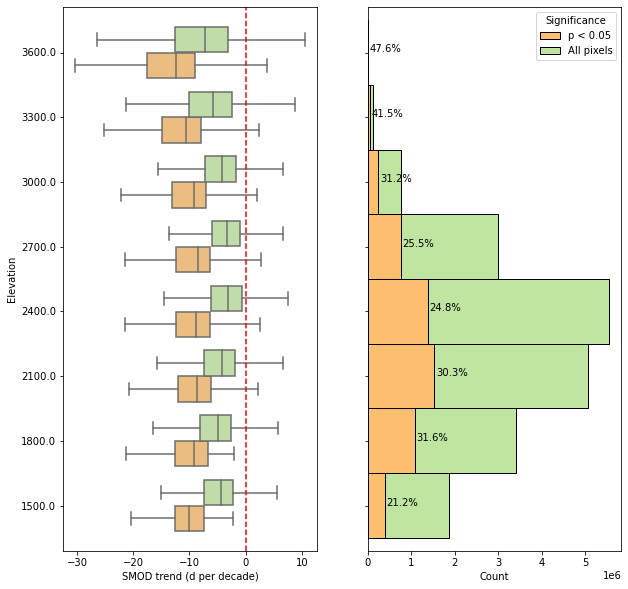

In [14]:
# D.2.4) MAKE BOXPLOT PER ELEVATION RANGE FOR THE ALPS
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pymannkendall as mk
import pandas as pd
def draw_text(plot,ax):
    w = []
    y = []
    for i,patch in enumerate(plot.patches):
        w.append(plot.patches[i].get_width())
        y.append(plot.patches[i].get_y())
    w = np.array(w).reshape(2, int(len(w)/2))
    y = np.array(y).reshape(2, int(len(y)/2))
    print(w,y)
    p = w[1]/w[0]*100
    print(p)
    for i in range(len(p)):
        plot.annotate("{:.1f}%".format(p[i]), xy=(w[1][i] + 40000 ,y[0][i] + 0.5))
        
        
with open( os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","DATAFRAMES","PIXEL_MK_MULTI_NOBS.pkl"), "rb" )  as dp:
    df = pickle.load(dp) 
plot_path =  os.path.join(project_dir,"DATA","SYNTHESIS","ANALYSIS","SAFRAN","PLOTS")
mtn = 'ALP'
print("prepare dataframes")

df_temp = df.sort_values(by=['ELEVATION']).query(f"ELEVATION <= 3600  & MTN == '{mtn}'")
df_temp = df_temp.rename(columns={"SIGNIFICANCE": "Significance"})
df_temp2 = df_temp.query("TREND != 'no trend'")
df_temp["Significance"] ="All pixels"
df_temp2["Significance"] ="p < 0.05"

df_temp = pd.concat([df_temp,df_temp2],ignore_index=True)

df_temp['ELEVATION'] = df_temp['ELEVATION'].astype(str)

hur_order=["p < 0.05","All pixels"]

print("start plots")
fig, axs = plt.subplots(1,2,sharey=True)
print("boxplot")
bp = sn.boxplot(ax=axs[0],data=df_temp,y="ELEVATION",x="SLOPE",hue="Significance",hue_order=hur_order, showfliers=False,palette='Spectral')
axs[0].invert_yaxis() 
axs[0].axvline(0, ls='--', color='red')
axs[0].legend_.remove()
axs[0].set_xlabel("SMOD trend (d per decade)")
axs[0].set_ylabel("Elevation")
#axs[0].set_xticklabels([-25,-20, -15, -10, -5,0])
print("histplot")
hs = sn.histplot(ax=axs[1],data=df_temp,y='ELEVATION',hue='Significance',hue_order=hur_order,alpha=1,palette='Spectral')
axs[1].invert_yaxis()
axs[1].set_xlabel("Count")

draw_text(hs,axs[1])
fig.set_figwidth(10)
fig.set_figheight(10)
plt.savefig(os.path.join(plot_path,f"{mtn}_pixel_trends.pdf"),format='pdf',transparent=False)


In [ ]:
# E) UNCERTAINTY ANALYSIS (SECTION CODED IN HAL BEFORE TREX AND NEEDS TO BE CLEANED)

In [ ]:
# E.1) CALCULATE DISTRIBUTION WEIGHTS OF SATELLITE DATA OVER THE INSITU STATIONS

In [ ]:
# E.1.1) PARSE STATIONS
points_shp_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/stations_tcd_50_massifs_prec4_nodoubles.shp"
srs =  osr.SpatialReference()
srs.ImportFromEPSG(4326)
drv = ogr.GetDriverByName( 'ESRI Shapefile' )
points_shp = drv.Open(points_shp_path)

layer_points = points_shp.GetLayer()
featureCount = layer_points.GetFeatureCount()
print(featureCount)

dict_tile_stations = {}
for f,feature in enumerate(layer_points):
    lon = feature['lon']
    lat = feature['lat']
    mtn = feature['mtn']
    print(f"parse stations {int(f/len(layer_points)*100)}%",end="                                               \r")
    for tile in S2_4326_tiles[mtn]:
        if lon > S2_4326_tiles[mtn][tile]["MAXX"] or lon < S2_4326_tiles[mtn][tile]["MINX"] or \
        lat > S2_4326_tiles[mtn][tile]["MAXY"] or lat < S2_4326_tiles[mtn][tile]["MINY"] : continue
        if tile not in dict_tile_stations : dict_tile_stations[tile] = []
        to_tile = pyproj.Transformer.from_crs(4326,int(epsg_list[tile]['EPSG']), always_xy=True)
        coord = to_tile.itransform([(lon,lat)]) 
        list_coord = [*coord] #only one coord
        dict_tile_stations[tile].append((feature,list_coord,get_station_data(feature['station id'], min_year = 1985, max_year = 2015)))

In [ ]:
# E.1.2) get days of spot acqui per month/year/station...


SWH_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/TCD-BLUE_AVG-1200"
list_swh_dates = list(dict.fromkeys(
[date(int(x.split("/")[-3]),int(x.split("/")[-2]),int(x.split("/")[-1])) for x in glob.glob(os.path.join(SWH_path,'*','*','*','*','*'))]))




SWH_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/TCD-BLUE_AVG-1200"
df_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_acquis_stations.pkl"
dict_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/dict_swh_acquis_stations.json"


d = dict()
d["ID"] = []
d["YEAR"] = []
d["MONTH"] = []
d["DAY"] = []
d["MTN"] = []
d["TILE"] = []
d["SAFRAN"] = []
d["SAFRAN_S"] = []
d["CLASS"] = []
d["SD_SIM"] = []
d["SD_OBS"] = []
nb_dates = len(list_swh_dates)
count = 0
for mtn in S2_4326_tiles:
    for tile in S2_4326_tiles[mtn]:
        for j,single_date in enumerate(list_swh_dates):
            year = single_date.year
            month = single_date.month
            day = single_date.day
            #get list of swh products
            print(f"{mtn} {tile} {int(j/nb_dates*100)}%  {count}",end="                                               \r")
            list_swh = glob.glob(os.path.join(SWH_path,mtn,'*',str(year),str(month),str(day),"*",tile,"*","*FSCTOC*"),recursive=True)
            if not list_swh: continue
            #get list of stations with data at that date for that tile
            list_stations = []
            v = 0
            for feature,list_coord,station_df in dict_tile_stations[tile]:
                v+=1
                #print(f"find stations {mtn} {tile} {day}/{month}/{year} {int(v/len(dict_tile_stations[tile])*100)}% {count}",end="                                               \r")
                try:
                    sd_sim = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_Crocus_assim']
                    sd_obs = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_obs']
                    list_stations.append((feature,list_coord,sd_sim,sd_obs))
                except KeyError:
                    continue
            if not list_stations : continue
            #get hydro date
            if single_date < date(int(single_date.year),9,1):
                annee_hydro = int(single_date.year) - 1
            else:
                annee_hydro = int(single_date.year)
            date_debut_hydro = date(annee_hydro,9,1)
            annee_hydro_jour = (single_date - date_debut_hydro).days + 1
            #check for swh/stations pairs
            for k,swh in enumerate(list_swh):
                #show progress
                #print(f"find pairs {mtn} {tile} {day}/{month}/{year} {int(k/len(list_swh)*100)}% {count}",end="                                               \r")
                with rasterio.open(swh) as src:
                    for feature,list_coord,sd_sim,sd_obs in list_stations:
                        for z in src.sample(list_coord,masked=True): 
                            if z[0] != '--' : 
                                pixel = float(z[0])
                                #print(pixel)
                                if pixel != 255 :
                                    d["YEAR"].append(annee_hydro)
                                    d["DAY"].append(annee_hydro_jour)
                                    d["MONTH"].append(month)
                                    d["TILE"].append(tile)
                                    d["MTN"].append(mtn)
                                    d["SAFRAN"].append(feature['title'])
                                    d["ID"].append(feature['station id'])
                                    d["SAFRAN_S"].append(feature['title_s'])
                                    d["CLASS"].append(pixel)
                                    d["SD_SIM"].append(sd_sim)
                                    d["SD_OBS"].append(sd_obs)
                                    count+=1
                                    
df = pd.DataFrame(data=d)   
df = df.drop_duplicates()
df["COLLECTION"]="SWH"
df.to_pickle(df_swh_path)

In [ ]:
# E.1.3) get days of landsat acqui per month/year/station...

DLR_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
list_dlr_dates = list(dict.fromkeys(
[getDateFromStr(x) for x in glob.glob(os.path.join(DLR_path,'*','*'))]))


DLR_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
df_dlr_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_landsat_acquis_stations.pkl"


d = dict()
d["ID"] = []
d["YEAR"] = []
d["MONTH"] = []
d["DAY"] = []
d["MTN"] = []
d["TILE"] = []
d["SAFRAN"] = []
d["SAFRAN_S"] = []
d["CLASS"] = []
d["SD_SIM"] = []
d["SD_OBS"] = []
nb_dates = len(list_dlr_dates)
count = 0
for mtn in S2_4326_tiles:
    for wrs in LANDSAT_tiles[mtn]:
        for j,single_date in enumerate(list_dlr_dates):
            str_date = single_date.strftime("%Y%m%d")
            year = single_date.year
            month = single_date.month
            day = single_date.day
            #get hydro date
            if single_date < date(int(single_date.year),9,1):
                annee_hydro = int(single_date.year) - 1
            else:
                annee_hydro = int(single_date.year)
            date_debut_hydro = date(annee_hydro,9,1)
            annee_hydro_jour = (single_date - date_debut_hydro).days + 1
            #get list of dlr products
            print(f"{mtn} {wrs} {int(j/nb_dates*100)}%  {count}",end="                                               \r")
            list_dlr = glob.glob(os.path.join(DLR_path,mtn+"_LIS",f"FSC_{str_date}T*_{wrs}",f"FSC_{str_date}T*_{wrs}_FSCTOC.tif"),recursive=True)
            if not list_dlr: continue
            for dlr in list_dlr:
                for tile in LANDSAT_tiles[mtn][wrs]:
                    #get list of stations with data at that date for that tile
                    list_stations = []
                    v = 0
                    for feature,list_coord,station_df in dict_tile_stations[tile]:
                        v+=1
                        #print(f"find stations {mtn} {tile} {day}/{month}/{year} {int(v/len(dict_tile_stations[tile])*100)}% {count}",end="                                               \r")
                        try:
                            sd_sim = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_Crocus_assim']
                            sd_obs = station_df.loc[single_date.strftime("%Y-%m-%d"), 'DSN_T_ISBA_obs']
                            list_stations.append((feature,list_coord,sd_sim,sd_obs))
                        except KeyError:
                            continue
                    if not list_stations : continue
                    #print(f"find pairs {mtn} {tile} {day}/{month}/{year} {int(k/len(list_swh)*100)}% {count}",end="                                               \r")
                    with rasterio.open(dlr) as src:
                        for feature,list_coord,sd_sim,sd_obs in list_stations:
                            for z in src.sample(list_coord,masked=True): 
                                if z[0] != '--' : 
                                    pixel = float(z[0])
                                    #print(pixel)
                                    if pixel != 255 :
                                        d["YEAR"].append(annee_hydro)
                                        d["DAY"].append(annee_hydro_jour)
                                        d["MONTH"].append(month)
                                        d["TILE"].append(tile)
                                        d["MTN"].append(mtn)
                                        d["SAFRAN"].append(feature['title'])
                                        d["ID"].append(feature['station id'])
                                        d["SAFRAN_S"].append(feature['title_s'])
                                        d["CLASS"].append(pixel)
                                        d["SD_SIM"].append(sd_sim)
                                        d["SD_OBS"].append(sd_obs)
                                        count+=1
                                    
df = pd.DataFrame(data=d)   
df = df.drop_duplicates()
df["COLLECTION"]="LANDSAT"
df.to_pickle(df_dlr_path)

In [ ]:
# E.1.4) MERGE DATAFRAME FROM BOTH SATELLITE COLLECTIONS
df_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_acquis_stations.pkl"
df_dlr_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_landsat_acquis_stations.pkl"
df_both_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_landsat_acquis_stations.pkl"

#causes de doublons:
# 1) stations dans zones chevauchement de tuile S2 ou wrs
# 2) meme date Landsat et SWH
# 3) risques que class ait différente valeur selon la tuile ou le satellite 

with open( df_swh_path, "rb" )  as f1, open( df_dlr_path, "rb" )  as f2:
    df = pd.concat([pickle.load(f1),pickle.load(f2)],ignore_index=True)
df["MONTH_N"] = df["MONTH"] 
print(df["CLASS"].unique())
df["MONTH"] = df['MONTH'].apply(lambda m: calendar.month_abbr[m])
df["CLASS"]= np.where(df['CLASS'] == 205.0, 'CLOUD', np.where(df['CLASS'] == 100.0, 'SNOW', 'GROUND'))
df.to_pickle(df_both_path)  #dataframe de stations par tuile (donc doublons dans les chevauchement
print(df["CLASS"].unique())


In [ ]:
# E.1.5) CALCULATE WEIGHTS
df_both_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_landsat_acquis_stations.pkl"
with open( df_both_path, "rb" )  as dp:
    df = pickle.load(dp)
    
df["SEASON"] =    np.where((df["MONTH_N"].isin([9,10,11])),"AUTUMN",np.where((df["MONTH_N"].isin([12,1,2])),"WINTER",np.where((df["MONTH_N"].isin([3,4,5])),"SPRING","SUMMER")))
df_u_sta_sat = df.loc[df.drop(columns=["TILE","CLASS"]).drop_duplicates().index]  
df_u_sta = df.loc[df.drop(columns=["TILE","CLASS","COLLECTION"]).drop_duplicates().index]  
print(df_u_sta_sat)
print(df_u_sta)

# make seasonal weigth range and get min and max NOBS
#df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_landsat_acquis.pkl"
#with open( df_path, "rb" )  as df:
#    df = pickle.load(df)

df = df_u_sta.query("YEAR >= 1986 & YEAR < 2015 & MTN == 'PYR'")
df = df[["YEAR","SEASON","DAY","ID"]]

df = df.drop_duplicates()

df["ACQUI"]  =1
df_minmax = df[["YEAR","ID","ACQUI"]].groupby(["YEAR","ID"], as_index=False).sum()


min_obs = df_minmax["ACQUI"].min()
max_obs = df_minmax["ACQUI"].max()
print(min_obs,max_obs)

df_seasons = df[["SEASON","ID","ACQUI"]].groupby(["SEASON","ID"], as_index=False).sum()
df_years =  df[["SEASON","ID","YEAR"]].groupby(["SEASON","ID"], as_index=False).nunique()
df_seasons["ACQUI"] = df_seasons["ACQUI"].div(df_years['YEAR'])
print(df_seasons)
fig, ax = plt.subplots()
sn.boxplot(data = df_seasons, x = "SEASON",y="ACQUI",order=["AUTUMN","WINTER","SPRING","SUMMER"],showfliers=False)
plt.savefig("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/PLOTS/seasons.pdf",format="pdf")

df = df_seasons[["SEASON","ACQUI"]].groupby(["SEASON"], as_index=False).mean()
df["WEIGHT"] = df["ACQUI"]/df["ACQUI"].sum()
dict_weights = dict(zip(df["SEASON"], df["WEIGHT"]))
dict_inverse_weights = dict()
v0= (1/dict_weights["AUTUMN"])
v1=(1/dict_weights["WINTER"])
v2=(1/dict_weights["SPRING"])
v3=(1/dict_weights["SUMMER"])
t=v0+v1+v2+v3
dict_inverse_weights["AUTUMN"]=(v0/t)
dict_inverse_weights["WINTER"]=(v1/t)
dict_inverse_weights["SPRING"]=(v2/t)
dict_inverse_weights["SUMMER"]=(v3/t)




        
print(dict_weights)
print(dict_inverse_weights)

In [ ]:
# E.2) STUDY RELATIONSHIP BETWEEN SMOD ERRORS AND NOBS BY SIMULATING SWH+DLR DISTRIBUTIONS WITH SENTINEL2 DATA

In [ ]:
# E.2.1) LOOK FOR ALL S2 FSC PRODUCTS OVER A YEAR OVER A TILE
tile = "31TCH"
FSC_list_path = f"/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/{tile}"
hydro_year = 2017

FSC_list = glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year)}*_[0-9]'),recursive=True) + glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year+1)}*_[0-9]'),recursive=True)
hydro_dict = {"AUTUMN":[],"WINTER":[],"SPRING":[],"SUMMER":[]}
hydro_list = []
weight_list = []

nb_of_FSC = 0
for FSC in FSC_list:
    fscdate = getDateFromStr(FSC)
    m = fscdate.month
    if fscdate >= date(hydro_year,9,2) and fscdate < date(hydro_year+1,9,1):
        season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
        hydro_dict[season].append(FSC)
        nb_of_FSC +=1
for season in hydro_dict:
    day_weight = dict_weights[season]/len(hydro_dict[season])
    for fsc in hydro_dict[season]:
        hydro_list.append(fsc)
        weight_list.append(day_weight)
        
        
print(nb_of_FSC)
print(hydro_list)
print(weight_list)
print(sum(weight_list))

In [ ]:
# E.2.2) RUN LIS SNOW SYNTHESIS FOR THE FULL S2 FSC TIME SERIE OF THE YEAR AND TILE
driver = gdal.GetDriverByName('GTiff')
output_dir_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/FULL"
mkdir_p(output_dir_path)
common_name = f"SY-FSC_T-{tile}_HY-{str(hydro_year)}_FULL-{str(nb_of_FSC)}"
synthese_dir_path = os.path.join(output_dir_path,str(hydro_year),common_name)
config_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/configs"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/logs"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
mkdir_p(synthese_dir_path)

#add zero image at each first september
nodata_path_first = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
nodata_tif_first = os.path.join(nodata_path_first,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif")
if not os.path.exists(nodata_tif_first):
    mkdir_p(nodata_path_first)
    nodata_array = np.zeros((5490,5490))
    outDs = driver.Create(nodata_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
    geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(nodata_array)
    outDs.SetGeoTransform(geotransform) 
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
    outDs.SetProjection(srs.ExportToWkt())
    outDs.FlushCache()   
hydro_list.append(nodata_path_first)


nodata_path_last = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}")
nodata_tif_last = os.path.join(nodata_path_last,f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}_FSCTOC.tif")
if not os.path.exists(nodata_tif_last):
    nodata_array = np.zeros((5490,5490))
    mkdir_p(nodata_path_last)
    outDs = driver.Create(nodata_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
    geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(nodata_array)
    outDs.SetGeoTransform(geotransform) 
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
    outDs.SetProjection(srs.ExportToWkt())
    outDs.FlushCache()   
hydro_list.append(nodata_path_last)


config = {
            "ram": 4096,
            "nb_threads": "8",
            "log_level": "INFO",
            }
config["tile_id"]=tile
config["date_start"]=(date(hydro_year,9,1)).strftime('%d/%m/%Y')
config["date_stop"]=(date(hydro_year+1,9,1)).strftime('%d/%m/%Y')
config["output_dates_filename"]= f"{common_name}.txt"
config["date_margin"]=0
config["input_products_list"]= hydro_list
config["config_file"]= f"{config_path}/{common_name}.json"
config["output_dir"]= synthese_dir_path
json_object = json.dumps(config, indent=4)
with open(config["config_file"], "w") as outfile:
    outfile.write(json_object)
job_name=common_name
os.system(f"qsub -o {log_path}/log.{job_name} -e {log_path}/log.{job_name} -v config=\"{config['config_file']}\" {job_sh_path}")    
        

In [ ]:
# E.2.3) ITERATIVELY REMOVE A S2 PRODUCT FROM THE FULL DATASET IN RESPECT TO THE WEIGHTS FROM E.1.5 AND RUN LIS SNOW SYNTHESIS EACH TIME
driver = gdal.GetDriverByName('GTiff')
output_dir_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/REDUCED/LS"
mkdir_p(output_dir_path)
config_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/configs"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/logs"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
print(nb_of_FSC,max_obs,min_obs)
num_del_start = min(nb_of_FSC - 1,max_obs)
num_del_end =  min_obs
#weight_list =  ((1/(df["WEIGHT"]))/(1/(df["WEIGHT"])).sum()).values.tolist()
#print(hydro_list)
for num_keep in range(num_del_start,num_del_end -1,-1):
    print(num_keep)
    for i in range(1,5):
        common_name = f"SY-FSC_T-{tile}_HY-{str(hydro_year)}_N-{str(num_keep)}_I-{str(i)}"
        synthese_dir_path = os.path.join(output_dir_path,str(hydro_year),str(num_keep),str(i),common_name)
        mkdir_p(synthese_dir_path)
        fsc_to_keep = (np.random.choice(hydro_list, num_keep, p=weight_list, replace=False)).tolist()
        
        
        #add zero image at each first september
        nodata_path_first = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
        nodata_tif_first = os.path.join(nodata_path_first,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif")
        if not os.path.exists(nodata_tif_first):
            mkdir_p(nodata_path_first)
            nodata_array = np.zeros((5490,5490))
            outDs = driver.Create(nodata_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
            geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
            outBand = outDs.GetRasterBand(1)
            outBand.WriteArray(nodata_array)
            outDs.SetGeoTransform(geotransform) 
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
            outDs.SetProjection(srs.ExportToWkt())
            outDs.FlushCache()   
        fsc_to_keep.append(nodata_path_first)
        
        
        nodata_path_last = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}")
        nodata_tif_last = os.path.join(nodata_path_last,f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}_FSCTOC.tif")
        if not os.path.exists(nodata_tif_last):
            nodata_array = np.zeros((5490,5490))
            mkdir_p(nodata_path_last)
            outDs = driver.Create(nodata_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
            geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
            outBand = outDs.GetRasterBand(1)
            outBand.WriteArray(nodata_array)
            outDs.SetGeoTransform(geotransform) 
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
            outDs.SetProjection(srs.ExportToWkt())
            outDs.FlushCache()   
        fsc_to_keep.append(nodata_path_last)
        
        
        
        
        season_count = {"AUTUMN":0,"WINTER":0,"SPRING":0,"SUMMER":0}
        config = {
            "ram": 4096,
            "nb_threads": "8",
            "log_level": "INFO",
            }
        config["tile_id"]=tile
        config["date_start"]=(date(hydro_year,9,1)).strftime('%d/%m/%Y')
        config["date_stop"]=(date(hydro_year+1,9,1)).strftime('%d/%m/%Y')
        config["output_dates_filename"]= f"{common_name}.txt"
        config["date_margin"]=0
        config["input_products_list"]= fsc_to_keep
        config["config_file"]= f"{config_path}/{common_name}.json"
        config["output_dir"]= synthese_dir_path
        json_object = json.dumps(config, indent=4)
        with open(config["config_file"], "w") as outfile:
            outfile.write(json_object)
        total =0
        for fsc in fsc_to_keep:
            fscdate = getDateFromStr(fsc)
            m = fscdate.month
            season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
            season_count[season]+=1
            total+=1
        print(f"try {i}",season_count,f'total {total}')
        job_name=common_name
        os.system(f"qsub -o {log_path}/log.{job_name} -e {log_path}/log.{job_name} -v config=\"{config['config_file']}\" {job_sh_path}")    
        
        
        


In [ ]:
# E.2.4) FOR EVERY ITERATIONS ASSOCIATE THE SMOD ERROR TO THE NOBS IN A DATAFRAME
df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_synthesis_smod_scd.pkl"
tile="31TCH"
DTM_PATH= glob.glob(op.join("/home/ad/barrouz/Neige/DEM",f"*{tile}*","*ALT_R2.TIF"))[0]
print(DTM_PATH)
TCD_PATH="/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"

hydro_year=2017
tcd_array = (gdal.Open(os.path.join(TCD_PATH,tile,f'TCD_{tile}.tif'))).ReadAsArray().flatten()
#dtm_array = (gdal.Open(DTM_PATH)).ReadAsArray().flatten()
full_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/SYNTHESIS/{tile}/FULL/{str(hydro_year)}"
nb = 10000

full_SMOD_path = glob.glob(os.path.join(full_path,'**','*SMOD*'),recursive=True)[0]
full_SCD_path = glob.glob(os.path.join(full_path,'**','*SCD*'),recursive=True)[0]
full_NOBS_path = glob.glob(os.path.join(full_path,'**','*NOBS*'),recursive=True)[0]
print(full_SMOD_path)

full_SMOD_array = (gdal.Open(full_SMOD_path).ReadAsArray()).flatten()
full_SCD_array = (gdal.Open(full_SCD_path).ReadAsArray()).flatten()
full_NOBS_array = (gdal.Open(full_NOBS_path).ReadAsArray()).flatten()
cond = np.where((tcd_array <= 50) & (full_SMOD_array > 0) )#& (dtm_array >= 1050))
full_SMOD_array = full_SMOD_array[cond]

pointsID = np.random.choice(range(len(full_SMOD_array)), nb, replace=False)
print(pointsID)

filtered_SMOD_array = np.take(full_SMOD_array,pointsID)

print("FULL SMOD",min(full_SMOD_array),max(full_SMOD_array))
print("FILTERED SMOD",min(filtered_SMOD_array),max(filtered_SMOD_array))
d = {"NOBS":[],"ΔSMOD":[],"SMOD":[],"INSITU_SMOD":[],"ALT":[]}
df = pd.DataFrame(data=d)
del full_SMOD_array, tcd_array,  #dtm_array,
for collection in ["LS"]:
    reduced_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/SYNTHESIS/{tile}/REDUCED/{collection}/{str(hydro_year)}"
    for N in sorted(os.listdir(reduced_path)):
        print("Reduced timeserie",N)
        for I in os.listdir(os.path.join(reduced_path,N)):
            #print("Iteration",I)
            SMOD_path = glob.glob(os.path.join(reduced_path,N,I,'**','*SMOD*'),recursive=True)[0]
            #print(SMOD_path)
            NOBS_path = glob.glob(os.path.join(reduced_path,N,I,'**','*NOBS*'),recursive=True)[0]
            #print(NOBS_path)
            NOBS_array = np.take((gdal.Open(NOBS_path).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            #print("NOBS",min(NOBS_array),max(NOBS_array),len(NOBS_array))
            SMOD_array = np.take((gdal.Open(SMOD_path).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            
            dtm_array = np.take((gdal.Open(DTM_PATH).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            #print("SMOD",min(SMOD_array),max(SMOD_array),len(SMOD_array))
            SMOD_residu =  (SMOD_array - filtered_SMOD_array)
            #print("SMOD RESIDU",min(SMOD_residu),max(SMOD_residu),len(SMOD_residu))
            #d["ID"].extend(pointsID)
            #d["SIZE"].extend([int(N)]*nb)
            #d["ITER"].extend([int(I)]*nb)
            d = {"NOBS":NOBS_array.tolist(),"ΔSMOD":SMOD_residu.tolist(),"SMOD":SMOD_array.tolist(),"INSITU_SMOD":filtered_SMOD_array.tolist(),"ALT":dtm_array.tolist()}
            df2 = pd.DataFrame(data=d)
            df = df.append(df2,ignore_index=True)
            #d["NOBS"].extend(NOBS_array)
            #d["SMOD"].extend(SMOD_array.tolist())
            #d["INSITU_SMOD"].extend(full_SMOD_array.tolist())
            #d["ΔSMOD"].extend(SMOD_residu)
            del NOBS_array, SMOD_array, SMOD_residu
#df = pd.DataFrame(data=d)
df.to_pickle(df_syn_path)





In [ ]:
# E.2.5) VIZUALIZE THE RELATIONSHIP BETWEEN THE SMOD ERROR TO THE NOBS

df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_synthesis_smod_scd.pkl"
with open( df_syn_path, "rb" )  as dp:
    df = pickle.load(dp)  
nobs_step = 5
df['NOBS_BIN'] = pd.cut(df['NOBS'],bins=range(0,101,nobs_step))
df['DATASET'] = 'Theia'
print(df)

def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):

    mae = median_absolute_error( g['INSITU_SMOD'], g['SMOD'] )
    return pd.Series( dict( mae = mae) )




plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

df2 = df.query('NOBS <= 28 & SMOD > 0 & ALT >= 1350' )
df_temp = df2.groupby(['NOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp["ΔSMOD_MEDIAN"] = df2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_MEDIAN"] = df2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_STD"] = df2.groupby(['NOBS'])['ΔSMOD'].std()
df_temp["ΔSMOD_Q1"] = df2.groupby(['NOBS'])['ΔSMOD'].quantile(0.25)
df_temp["ΔSMOD_Q3"] = df2.groupby(['NOBS'])['ΔSMOD'].quantile(0.75)
df_temp["ΔSMOD_IQR"]  = df_temp.ΔSMOD_Q3  - df_temp.ΔSMOD_Q1 
df_temp["ΔSMOD_COUNT"] = df2.groupby(['NOBS'])['ΔSMOD'].count()
df_temp["ci95_lo"] = df_temp.ΔSMOD_MEAN - 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ci95_hi"] = df_temp.ΔSMOD_MEAN + 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ΔSMOD_CI"]  = df_temp.ci95_hi  - df_temp.ci95_lo 
df_temp[["SMOD_R2",'SMOD_RMSE']]  =  df2.groupby(['NOBS']).apply( r2_rmse_interval )
df_temp[['SMOD_MAE']]  =  df2.groupby(['NOBS']).apply( mae_interval )
df_temp=df_temp.reset_index()

df_temp = df_temp.melt(id_vars=['NOBS'], value_vars=['SMOD_MAE','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')

print(df2.groupby("NOBS")["ΔSMOD"].median())


fig, ax = plt.subplots(2,1,sharex=True)
df2['NOBS'] = df2['NOBS'].astype('int')
g1 = sn.boxplot(data=df2,x='NOBS',y='ΔSMOD',showfliers = False,ax=ax[0],palette=['green'])
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].legend(bbox_to_anchor=[0.7, 0.95])
ax[0].axvline(26, color='black')
g1.set(xlabel=None)






df_temp = df_temp.replace("SMOD_MAE","ΔSMOD MAE")
df_temp = df_temp.replace("ΔSMOD_IQR","ΔSMOD IQR")
df_temp = df_temp.replace("SMOD_RMSE","ΔSMOD RMSE")
df_temp['DATASET'] = 'S2L8'
ax[1].grid(axis="both",which="major")
ax[1].set_axisbelow(True)
g2 = sn.scatterplot(data=df_temp,x='NOBS',y='METRIC_VALUE',style='ΔSMOD_METRIC',color='green', ax=ax[1])
plt.xticks(rotation=45)
offset = matptrans.ScaledTranslation(-0.91, 0, ax[1].figure.dpi_scale_trans)
trans = ax[1].collections[0].get_transform()
ax[1].collections[0].set_transform(trans + offset)
ax[1].legend(title="ΔSMOD METRIC",ncol=3,bbox_to_anchor=[0.35, 0.75])
ax[1].set_ylabel("VALUE")
ax[1].axvline(26, color='black')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.tight_layout()
crop = matptrans.Bbox.from_extents(0, 0, 0.7, 1)
plt.savefig(op.join(plot_path,f'S2L8_sim.png'),format="png",transparent=False,facecolor='white', dpi=300)
